<a href="https://colab.research.google.com/github/Bourbon-Rye/Baesian-Cropability/blob/main/PilipiNuts_2023_Baesian_Cropability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Note: See Hypothesis Testing RESULTS in `results/`.

Set `INTERACTIVE` global variable (below) to <span style="color:blue">True</span> for interactive plots and <span style="color:blue">False</span> for static plots.

In [1]:
# @Libraries
import numpy as np
import pandas as pd
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import json
import re
import functools

from pathlib import Path
from sklearn import preprocessing
from plotly.subplots import make_subplots
from plotly import offline
from scipy import stats
from sklearn.impute import SimpleImputer
from matplotlib import figure

INTERACTIVE = False

def render(fig: figure.Figure):
    if INTERACTIVE:
        fig.show()
    else:
        fig.update_layout(
            autosize=False,
            width=1280,
            height=720,
        )
        fig.show(renderer="png")

In [2]:
# @title Corrections
with open('datasets/region_provinces.json') as jsonfile:
    regions_provinces = json.load(jsonfile)['PHILIPPINES']
regions_provinces = {key.lower():regions_provinces[key] for key in regions_provinces}
regions = regions_provinces.keys()
provinces = set([item.lower() for key in regions for item in regions_provinces[key]])
regions = set(regions)
regions.add("philippines")

# NOTE: Fix for bad regions, thanks PSA
bad_regions = ['AONCR', 'BARMM', 'CAR', 'MIMAROPA', 'NCR',
           'Region 1', 'Region 2', 'Region 3', 'Region 4A',
           'Region 5', 'Region 6', 'Region 7', 'Region 8',
           'Region 9', 'Region 10', 'Region 11', 'Reg12', 'CARAGA']
region_mapping = {bad.lower():good.lower() for (bad,good) in zip(bad_regions, regions_provinces.keys())}
corrections = {
    "AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)": "bangsamoro autonomous region in muslim mindanao (barmm)",
    "autonomous region in muslim mindanao (armm)": "bangsamoro autonomous region in muslim mindanao (barmm)",
    "mimaropa region": "mimaropa region (mimaropa)"
}
region_mapping.update(corrections)

temp = [key.split('(')[1].rstrip(')') for key in regions_provinces]
region_short_to_long = {bad:good for (bad,good) in zip(temp, regions_provinces.keys())}
region_long_to_short = {v: k for k, v in region_short_to_long.items()}

In [3]:
# @title Utilities
def read_csv_to_df(csvfile: Path, comment_symbol='#') -> pd.DataFrame:
    """Read CSV to DataFrame with comment validation.
        Allows comment lines in CSVs where line[0] == comment_symbol.
        Also removes newlines.
        Does not recognize comment_symbol anywhere else. 
    """
    tempfile = Path('temp.csv')
    with open(csvfile, 'r') as csv, open(tempfile, 'w+') as temp:
        lines = csv.readlines()
        for line in lines:
            if line[0] != comment_symbol:
                temp.write(line)
    return pd.read_csv(tempfile)

def is_region(x: str, regions=regions) -> bool:
    x = x.strip(' .')
    x = x.lower()
    if x == "cagayan":
        return False
    for region in regions:
        if x in region:
            return True
    else:
        return False
    
def is_province(x: str, provinces=provinces) -> bool:
    x = x.strip(' .')
    x = x.lower()
    for province in provinces:
        if x in province:
            return True
    else:
        return False

def get_quarter_columns(df: pd.DataFrame, year_range: range, period_idx: int):
    """Assumes contiguous period (Year Month) columns and that columns before period_idx are ID columns"""
    df_quarter = df.iloc[:, :period_idx].copy()
    for year in year_range:
        for q in range(0, 12, 3):
            df_quarter[f"{year} Q{q//3+1}"] = df.filter(regex=str(year), axis=1).iloc[:, q:q+3].mean(axis=1)
    return df_quarter

def get_annual_columns(df: pd.DataFrame, year_range: range, period_idx: int):
    """Assumes contiguous period (Year Month|Quarter) columns and that columns before period_idx are ID columns
    Note that this also works with Quarters"""
    df_annual = df.iloc[:, :period_idx].copy()
    for year in year_range:
        df_annual[f"{year}"] = df.filter(regex=str(year), axis=1).mean(axis=1)
    return df_annual

def swap_columns(df: pd.DataFrame, col1: str, col2: str):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

def normalize(df: pd.DataFrame, col: str, minmax = True):
    """Can use mean normalization and minmax normalization."""
    tdf = df[col]
    if minmax:
        tdf = (tdf-tdf.min())/(tdf.max()-tdf.min())
    else:
        tdf = (tdf-tdf.mean())/tdf.std()
    df[col] = tdf
    return df

def drop_rows_with_zeros(df: pd.DataFrame, ref_col_idx: int, all_zeros=False):
    """Drop rows if some values are zeros, or if all values are zeros.
    Assumes contiguous reference columns, i.e. columns to use in deciding whether to drop."""
    return df[~(df.iloc[:, ref_col_idx:] == 0).all(axis=1)] if all_zeros else df[~(df.iloc[:, ref_col_idx:] == 0).any(axis=1)]

def dual_plot(df: pd.DataFrame, x: str, y1: str, y2: str,
              title=None, xtitle=None, y1title=None, y2title=None):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Add traces
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y1], name=y1),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y2], name=y2),
        secondary_y=True,
    )
    # # Add titles
    if title is not None: fig.update_layout(title_text=title)
    if xtitle is not None: fig.update_xaxes(title_text=xtitle)
    if y1title is not None: fig.update_yaxes(title_text=y1title, secondary_y=False)
    if y2title is not None: fig.update_yaxes(title_text=y2title, secondary_y=True)

    return fig


def triplet_plot(df: pd.DataFrame, x: str, y1_1: str, y1_2: str, y2: str,
                 title=None, xtitle=None, y1title=None, y2title=None):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Add traces
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y1_1], name=y1_1),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y1_2], name=y1_2),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y2], name=y2),
        secondary_y=True,
    )
    # # Add titles
    if title is not None: fig.update_layout(title_text=title)
    if xtitle is not None: fig.update_xaxes(title_text=xtitle)
    if y1title is not None: fig.update_yaxes(title_text=y1title, secondary_y=False)
    if y2title is not None: fig.update_yaxes(title_text=y2title, secondary_y=True)

    return fig

def quartet_plot(df: pd.DataFrame, x: str, y1_1: str, y1_2: str, y2_1: str, y2_2: str,
                 title=None, xtitle=None, y1title=None, y2title=None):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Add traces
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y1_1], name=y1_1),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y1_2], name=y1_2),
        secondary_y=True,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y2_1], name=y2_1),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=df[x], y=df[y2_2], name=y2_2),
        secondary_y=True,
    )
    # # Add titles
    if title is not None: fig.update_layout(title_text=title)
    if xtitle is not None: fig.update_xaxes(title_text=xtitle)
    if y1title is not None: fig.update_yaxes(title_text=y1title, secondary_y=False)
    if y2title is not None: fig.update_yaxes(title_text=y2title, secondary_y=True)

    return fig

def move_column(df: pd.DataFrame, col: str, new_idx: int):
    """This is an inplace method."""
    df.insert(new_idx, col, df.pop(col))
    
def preprocess_baesians_1(df: pd.DataFrame, commodity: str, rename_to: str, melt_value: str|None, regional=True):
    """Assumes Geolocation | Commodity | Period columns.
    Filters to regional if regional=True, else filters to provincial. Retains "philippines".
    """
    # df.dropna(inplace=True)
    df["Geolocation"] = df["Geolocation"].str.lstrip(".").str.lower()
    df["Geolocation"] = df["Geolocation"].replace(region_mapping)
    df = df[df["Geolocation"].apply(is_region)] if regional else df[df["Geolocation"].apply(is_province)]
    df = df[df["Commodity"] == commodity]
    df["Commodity"] = rename_to # Rename everything in Commodity to Rice
    if melt_value:
        df = df.melt(id_vars=["Geolocation", "Commodity"], value_vars=df.columns[2:], var_name="Period", value_name=melt_value)
    return df

def imputer(df: pd.DataFrame, start_idx: int, end_idx=None):
    """If only start index is provided, will impute from start index column to last column,
    else limit from start_idx to end_idx. Inplace imputation"""
    imp = SimpleImputer(missing_values=pd.NA, strategy='mean')
    if end_idx:
        imp.fit(df.iloc[:, start_idx:end_idx])
        df[df.columns[start_idx:end_idx]] = imp.transform(df.iloc[:, start_idx:])
    else:
        imp.fit(df.iloc[:, start_idx:])
        df[df.columns[start_idx:]] = imp.transform(df.iloc[:, start_idx:])

def preprocess_baesians_2(df: pd.DataFrame, commodity_map: dict, melt_value: str|None, regional=True, impute=False):
    """Assumes Geolocation | Commodity | Period ... columns.
    Filters to regional if regional=True, else filters to provincial. Retains "philippines".
    Filters to raw commodity name (key in commodity_map), and then renames to standard commodity_map[key]
    Ex. {"RICE, REGULAR-MILLED, 1 KG" : "Rice"}
    """
    df["Geolocation"] = df["Geolocation"].str.lstrip(".").str.lower()
    df["Geolocation"] = df["Geolocation"].replace(region_mapping)
    df = df[df["Geolocation"].apply(is_region)] if regional else df[df["Geolocation"].apply(is_province)]
    df = df[df["Commodity"].isin(commodity_map)]
    df.loc[:, "Commodity"] = df["Commodity"].replace(commodity_map)
    if melt_value:
        df = df.melt(id_vars=["Geolocation", "Commodity"], value_vars=df.columns[2:], var_name="Period", value_name=melt_value)
    if impute:
        imputer(df, 3)  # inplace imputation of melt_value
    return df

def filter_to_regions(df: pd.DataFrame):
    return df[df["Geolocation"].apply(is_region)]
    
def filter_to_provinces(df: pd.DataFrame):
    return df[df["Geolocation"].apply(is_province)]

def fig_to_div(fig: figure.Figure, filename: Path):
    """Optional: Add pretiffication."""
    filename = Path(filename)
    filename.parent.mkdir(exist_ok=True, parents=True)
    with open(filename, "w+") as f:
        f.write(offline.plot(fig, include_plotlyjs=False, output_type='div'))
        
def fig_to_html(fig: figure.Figure, filename: Path):
    filename = Path(filename)
    filename.parent.mkdir(exist_ok=True, parents=True)
    fig.write_html(filename)
    
def fig_to_png(fig: figure.Figure, filename: Path):
    """NOTE: Requires ORCA to be installed!"""
    filename = Path(filename)
    filename.parent.mkdir(exist_ok=True, parents=True)
    fig.update_layout({
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    })
    pio.write_image(fig, filename,scale=6, width=900, height=680)
    
def p_report(p: int) -> str|int:
    if p >= 0.001:
        return round(p, 3)
    elif p < 0.001:
        return "<0.001"
    else:
        return np.nan
    

In [4]:
# @title OTG Cleanup
# VALUE OF PRODUCTION (5/24/2024)
datapath = Path("datasets/agricultural-indicators/value-of-production/")
writepath = Path("datasets")

files = list(datapath.glob("*.csv"))
df = pd.DataFrame()
for file in files:
    with open(file) as f:
        region = f.readlines()[0].split(':')[0].lstrip("\"")
        if region == u"\ufeffTest\n":
            region = "Cordillera Administrative Region (CAR)"
        tdf = pd.read_csv(file, skiprows=1, na_values=".")
        tdf["Geolocation"] = region
        df = pd.concat([df, tdf])
df["Subsector"] = "Rice"
df.drop(columns=["Type of Valuation"], inplace=True)
df.rename({"Subsector": "Commodity"}, axis=1, inplace=True)

# Imputation of VOP df
imp = SimpleImputer(missing_values=pd.NA, strategy='mean')
imp.fit(df.iloc[:, 1:-1])
df[df.columns[1:-1]] = imp.transform(df.iloc[:, 1:-1])
move_column(df, "Geolocation", 0)
df_val_of_prod = df

# ANNUAL RICE STOCKS (5/24/2024) NOTE: Perhaps try to match this with the prices as this has monthly, for national only
df = read_csv_to_df("datasets/agricultural-indicators/stocks-palay-corn_yearly_1980-2024.csv")
df = df[(df["Sector"] == "Rice: Total Stock") | (df["Sector"] == "Corn: Total Stock")]
df["Sector"] = df["Sector"].replace({"Rice: Total Stock": "Rice", "Corn: Total Stock": "Corn"})
df = pd.concat([df.iloc[:, :2].copy(), df.mean(axis=1, numeric_only=True)], axis=1)
df.rename(columns={"Sector": "Commodity", "Year": "Period", 0: "Stocks"}, inplace=True)
df = df[df["Period"].isin(range(2012, 2024))]
df_stocks = df

# Baesian Plots


Hypotheses:
- **H0.1:** There is no significant difference in the productivity of major food crops when grouped according to their crop type, geolocation, and/or market profile.
- **H0.2:** There is no significant relationship between market conditions and food crop production.

Goal: Visually and statistically assess the relationship between market indicators and crop yield indicators.

Visual tests are dual plots and scatterplots. Statistics for relationship testing: contingency tables and t-tests (?).

## Data Overview

Selected major crops (analyzed are checked):
- ✅ Rice / Palay
- ✅ Corn / Maize
- Sweet Potato / Camote
- Mongo / Monggo / Mung Beans
- Banana
- Coconut
- Onion
- Garlic
- Sugarcane

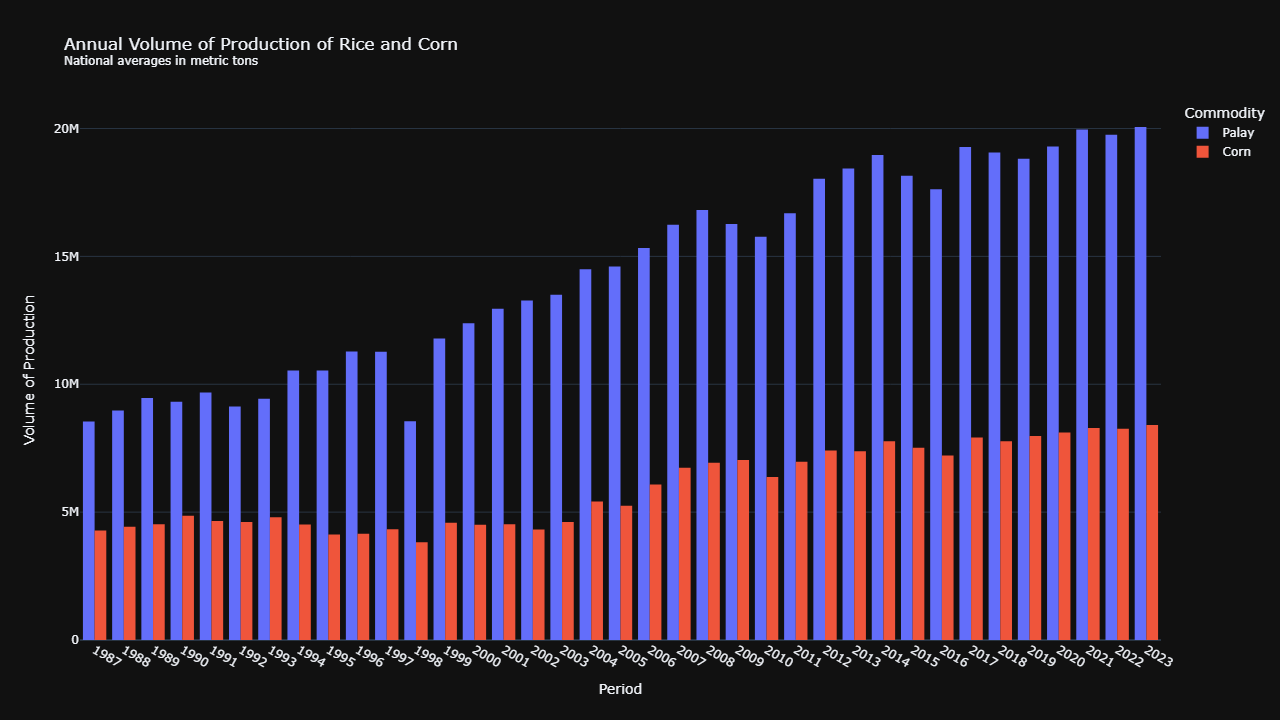

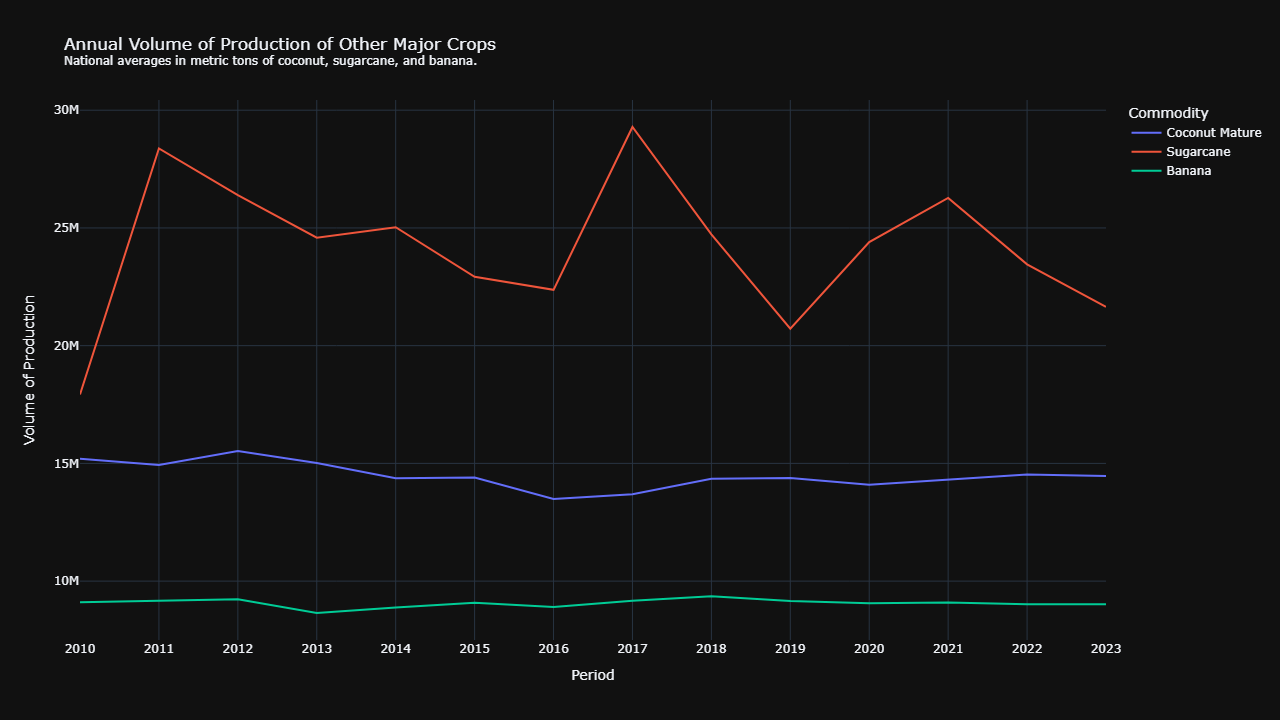

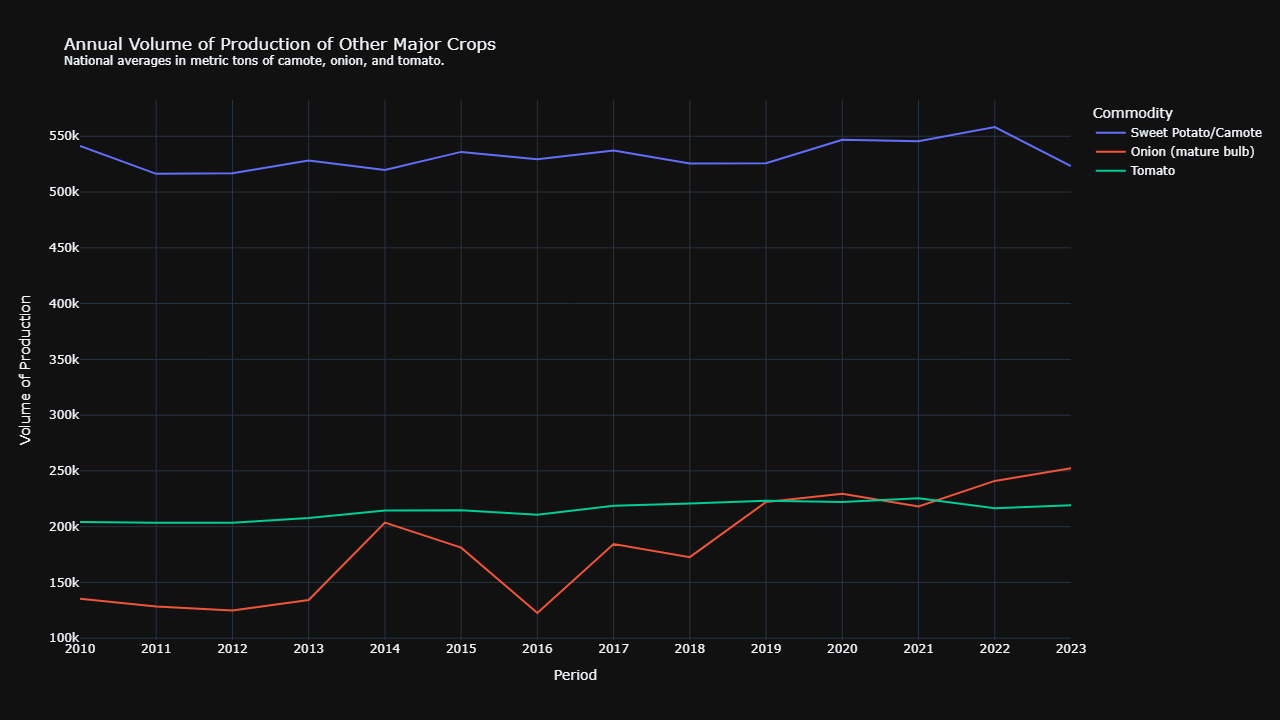

In [5]:
# Volume of Production of Selected Major Crops
df = pd.read_csv("datasets/agricultural-indicators/volume_rice-corn.csv", skiprows=2)
df = df[df["Geolocation"] == "PHILIPPINES"]
df = df[(df["Commodity"] == "Palay") | (df["Commodity"] == "Corn")]
df = df.filter(regex="Commodity|Geolocation|Annual", axis=1)
df.columns = map(lambda x: x.replace(" Annual", "") if "Annual" in x else x, df.columns)
df = df.melt(id_vars=["Commodity", "Geolocation"], value_vars=df.columns[2:], var_name="Period", value_name="Volume")
fig = px.histogram(df, x="Period", y="Volume", color="Commodity", barmode='group',
                   title='Annual Volume of Production of Rice and Corn<br><sup>National averages in metric tons</sup>').update_layout(
    xaxis_title="Period", yaxis_title = "Volume of Production", template="plotly_dark")
render(fig)

df = pd.read_csv("datasets/agricultural-indicators/volume_other-crops.csv", skiprows=2)
df = df[df["Geolocation"] == "PHILIPPINES"]
df = df[df["Commodity"].isin(["Coconut Mature", "Sugarcane", "Banana"])]
df = df.filter(regex="Commodity|Geolocation|Annual", axis=1)
df.columns = map(lambda x: x.replace(" Annual", "") if "Annual" in x else x, df.columns)
df = df.melt(id_vars=["Commodity", "Geolocation"], value_vars=df.columns[2:], var_name="Period", value_name="Volume")
fig = px.line(df, x="Period", y="Volume", color="Commodity",
              title='Annual Volume of Production of Other Major Crops<br><sup>National averages in metric tons of coconut, sugarcane, and banana.</sup>').update_layout(
    xaxis_title="Period", yaxis_title = "Volume of Production", template='plotly_dark')
render(fig)

df = pd.read_csv("datasets/agricultural-indicators/volume_other-crops.csv", skiprows=2)
df = df[df["Geolocation"] == "PHILIPPINES"]
df = df[df["Commodity"].isin(["Tomato", "Onion (mature bulb)", "Sweet Potato/Camote"])]
df = df.filter(regex="Commodity|Geolocation|Annual", axis=1)
df.columns = map(lambda x: x.replace(" Annual", "") if "Annual" in x else x, df.columns)
df = df.melt(id_vars=["Commodity", "Geolocation"], value_vars=df.columns[2:], var_name="Period", value_name="Volume")
fig = px.line(df, x="Period", y="Volume", color="Commodity", title='Annual Volume of Production of Other Major Crops<br><sup>National averages in metric tons of camote, onion, and tomato.</sup>').update_layout(
    xaxis_title="Period", yaxis_title = "Volume of Production", template='plotly_dark')
render(fig)

## Annual Analysis
Annual-National and Annual-Regional analysis of the commodities Rice and Corn. Other major crops to follow.

**NOTE:** The core agricultural indicators are Stocks, Volume, and Area Harvested, while the core market indicators are Farmgate Price, Wholesale Price, and Retail Price.

This is important to know especially during visualization where Farmgate price is used as a slicer.

### Data Preprocessing

In [6]:
# @title Annual megadataset for rice and corn
# NOTE: Filter this during visualization and analysis to just Philippines or Regions
def filter_period(df: pd.DataFrame, _type: str):
    if _type == "Annual":
        df = df.filter(regex="Commodity|Geolocation|Annual", axis=1)
        df.columns = map(lambda x: x.replace(" Annual", "") if "Annual" in x else x, df.columns)
    elif _type == "Quarterly":
        df = df.filter(regex="Commodity|Geolocation|Q\d", axis=1)
    return df

# Volume of Rice and Corn
df1 = pd.read_csv("datasets/agricultural-indicators/volume_rice-corn.csv", skiprows=2, na_values=[".."])
df1 = filter_period(df1, "Annual")
df1 = preprocess_baesians_2(df1, {"Palay": "Rice", "Corn": "Corn"}, melt_value="Volume")

df1_1 = pd.read_csv("datasets/agricultural-indicators/volume_other-crops.csv", skiprows=2, na_values=[".."])
df1_1 = filter_period(df1_1, "Annual")
df1_1 = preprocess_baesians_2(df1_1, {"Onion (mature bulb)": "Onion", "Garlic (Dried bulb)": "Garlic"}, melt_value="Volume")

# Farmgate Price of Rice and Corn
df2 = pd.read_csv("datasets/prices/prices_farmgate-new-series_2010-2023.csv")
df2 = get_annual_columns(df2, range(2012, 2024), 2)
df2 = preprocess_baesians_2(df2, {"Palay [Paddy] Other Variety, dry (conv. to 14% mc)": "Rice",
                                  "Corngrain [Maize] Yellow, matured": "Corn",
                                  "Onion Red Creole (Bermuda Red)": "Onion",
                                  "Garlic": "Garlic"}, melt_value="Farmgate Price")

# Wholesale Price of Rice and Corn
df3 = pd.read_csv("datasets/prices/prices_wholesale-new-series_2010-2023.csv",)
df3 = get_annual_columns(df3, range(2012, 2024), 2)
df3 = preprocess_baesians_2(df3, {"Well Milled Rice (WMR)": "Rice",
                                  "Corngrits White": "Corn",
                                  "Onion Red Creole (Bermuda Red)": "Onion",
                                  "Garlic": "Garlic"}, melt_value="Wholesale Price")

# Retail Price of Rice and Corn
df4 = pd.read_csv("datasets/prices/prices_retail_2012-2023.csv")
df4 = get_annual_columns(df4, range(2012, 2024), 2)
df4 = preprocess_baesians_2(df4, {"RICE, REGULAR-MILLED, 1 KG": "Rice",
                                  "RICE, REGULAR MILLED, LOOSE, 1 KG" : "Rice",
                                  'WHOLE CORN GRAIN, YELLOW, 1 KG': "Corn",
                                  "ONION RED CREOLE (BERMUDA RED), 1 KG": "Onion",
                                  "GARLIC, NATIVE, 1 KG": "Garlic"}, melt_value="Retail Price")

# Area Harvested of Rice and Corn
df5 = pd.read_csv("datasets/agricultural-indicators/area-harvested-palay-corn_quarterly-annual_2010-2023.csv", skiprows=2)
df5 = filter_period(df5, "Annual")
df5 = preprocess_baesians_2(df5, {"Palay": "Rice", "Corn": "Corn"}, melt_value="Area Harvested")

df5_1 = pd.read_csv("datasets/agricultural-indicators/area-harvested-by-crop-by-region_quarterly-annual_2013-2023.csv", skiprows=2)
df5_1 = filter_period(df5_1, "Annual")
df5_1 = preprocess_baesians_2(df5_1, {"Onion (mature bulb)": "Onion",
                                      "Garlic (bulb)": "Garlic"}, melt_value="Area Harvested")

# Consumer Price Index (All Income) per Region of Rice and Corn
df6 = pd.read_csv("datasets/price-indices-2018-based/cpi_all-income-households-by-cg-with-backcasting_1994-2023.csv")
df6 = get_annual_columns(df6, range(2012, 2024), 2)
df6 = preprocess_baesians_2(df6, {"01.1.1.12 - Rice": "Rice",
                                  "01.1.1.16 - Corn": "Corn",
                                  "01.1.7 - Vegetables, tubers, plantains, cooking bananas and pulses (ND)": "Onion"},
                            melt_value="CPI All Income")

# Consumer Price Index (Bottom 30) per Region of Rice and Corn
df7 = pd.read_csv("datasets/price-indices-2018-based/cpi_bottom-30-by-cg-with-backcasting_2012-2017.csv")
df7 = preprocess_baesians_2(df7, {"01.1.1.12 - Rice": "Rice", "01.1.1.16 - Corn": "Corn"}, melt_value=None)
tdf = pd.read_csv("datasets/price-indices-2018-based/cpi_bottom-30-by-cg_2018-2023.csv")
tdf = preprocess_baesians_2(tdf, {"01.1.1.12 - Rice": "Rice", "01.1.1.16 - Corn": "Corn"}, melt_value=None)
df7 = pd.merge(df7, tdf, on=["Geolocation", "Commodity"])
df7 = get_annual_columns(df7, range(2012, 2024), 2)
df7 = preprocess_baesians_2(df7, {"Rice": "Rice", "Corn": "Corn"}, melt_value="CPI Bottom 30")

# Costs and Returns per Region of Rice and Corn
df8 = pd.read_csv("datasets/agricultural-indicators/costs-and-returns_rice-and-corn.csv", skiprows=1, na_values=[".."])
df8 = df8[df8["Item"] == "NET RETURNS"]
df8.drop("Item", axis=1, inplace=True)
df8.rename({"Type": "Commodity"}, axis=1, inplace=True)
df8 = preprocess_baesians_2(df8, {"All Palay": "Rice", "All Corn": "Corn"}, melt_value="Net Returns")
df8 = df8[df8["Period"].str.contains("Average")]
df8["Period"] = df8["Period"].apply(lambda x: x.split()[1])

# National Inflation Rate
df9 = pd.read_csv("datasets/statista_inflation-rate-in-the-philippines-2029.csv", dtype={"Period": object, "Inflation Rate": float})

# NCR Retail Price Index on Food
df10 = pd.read_csv("datasets/price-indices-2018-based/rpi-in-ncr_food-only_1998-2023.csv")
df10 = get_annual_columns(df10, range(2010, 2024), 2)
df10 = preprocess_baesians_2(df10, {"Food": "Food"}, melt_value="NCR RPI").drop(["Geolocation", "Commodity"], axis=1)

# Agricultural Self-Sufficiency for Rice and Corn
df11 = pd.read_csv("datasets/agricultural-indicators/agri-self-sufficiency-ratio.csv", skiprows=1)
df11 = df11[(df11["Commodity"] == "Rice") | (df11["Commodity"] == "Corn")]
df11 = df11.melt("Commodity", df11.columns[1:], "Period", "Self-Sufficiency Ratio")

# Agricultural Import-Dependency for Rice and Corn
df12 = pd.read_csv("datasets/agricultural-indicators/agri-import-dependency-ratio.csv", skiprows=1)
df12 = df12[(df12["Commodity"] == "Rice") | (df12["Commodity"] == "Corn")]
df12 = df12.melt("Commodity", df12.columns[1:], "Period", "Import-Dependency Ratio")

# SU Gross Supply and UT Total Net Food Disposable for Rice and Corn
# Explained here: https://openstat.psa.gov.ph/Metadata/2B5FSUA0
df13 = pd.read_csv("datasets/agricultural-indicators/SUT_Rice and Corn.csv")
df13 = df13.filter(regex="Commodity|Year|Gross|Food")
df13.rename({"Year": "Period", "UT Total Net Food Disposable": "UT Consumable"}, axis=1, inplace=True)
df13.Period = df13.Period.astype(str)

# Merge all dfs into a single df
# NOTE: Remove df8 or add more year data or commodities to increase number of samples
# NOTE: You may adjust here which dfs are included in the final df
# NOTE: df8, df10, df11, df12, and df13 are all only until 2021 and 2022... respectively
UNTIL_2023 = False
if UNTIL_2023:
    dfs = [df1, df2, df3, df4, df5, df6, df7, df9]
    df = functools.reduce(lambda left, right: pd.merge(left, right), dfs)
else:
    dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13]
    df = functools.reduce(lambda left, right: pd.merge(left, right), dfs)
    move_column(df, "Area Harvested", 4)
    move_column(df, "Self-Sufficiency Ratio", 5)
    move_column(df, "Import-Dependency Ratio", 6)
    move_column(df, "SU Gross Supply", 7)
    move_column(df, "UT Consumable", 8)

# # Stocks of Rice (Annual)
tdf1 = df_stocks.copy()
tdf2 = df[["Commodity", "Period"]].copy()
tdf2["Period"] = pd.to_numeric(tdf2["Period"])
df.insert(3, "Stocks", pd.merge(tdf2, tdf1)["Stocks"])

# Additional Datasets -------------------------------------
# Uncomment the merge to include
# Poverty Incidence per Region (only on 2015, 2018, 2021)
df_poverty = pd.read_csv("datasets/poverty_incidence.csv", skiprows=1)
df_poverty["Commodity"] = "Rice"
df_poverty = preprocess_baesians_2(df_poverty, {"Rice": "Rice"}, melt_value="Poverty Incidence")
df_poverty.drop("Commodity", axis=1, inplace=True)

# df = pd.merge(df, df_poverty) # NOTE: Uncomment to include

# Enrollment Rate per Region
df_enrollment = pd.read_csv("datasets/enrollment.csv", na_values=[".."])
df_enrollment["Geolocation"] = df["Geolocation"].str.lower().replace(region_short_to_long)
df_enrollment = df_enrollment.filter(regex="Geolocation|Both Sexes")
df_enrollment.rename(lambda x: x.split()[2] if "Both" in x else x, axis=1, inplace=True)
df_enrollment = df_enrollment.melt(["Geolocation"], df_enrollment.columns[1:], "Period", "Enrollment Rate")

# df = pd.merge(df, df_enrollment) # NOTE: Uncomment to include

# Cleanup
del dfs, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13

if True:
    df.to_csv("datasets/annual-regional_megadataset_inner-join.csv", index=False)
    
df.describe()

,Stocks,Volume,Area Harvested,Self-Sufficiency Ratio,Import-Dependency Ratio,SU Gross Supply,UT Consumable,Farmgate Price,Wholesale Price,Retail Price,CPI All Income,CPI Bottom 30,Net Returns,Inflation Rate,NCR RPI
count,340.000000,3.400000e+02,3.400000e+02,340.00000,340.00000,340.000000,340.00000,330.000000,252.000000,244.000000,340.000000,340.000000,305.000000,340.000000,340.000000
mean,1485.030538,1.558783e+06,4.275902e+05,91.11000,8.89500,12609.000000,7286.35000,15.157641,33.806509,35.386332,92.842937,93.060681,16309.521311,2.813000,112.559167
std,892.227575,3.314457e+06,8.629677e+05,4.80195,4.80107,3935.472969,5210.44233,2.901644,6.415134,8.506258,10.446669,10.317620,10258.809888,1.251995,8.668396
min,320.012308,5.865700e+04,2.449600e+04,79.80000,1.80000,7710.000000,1569.00000,9.174167,18.000000,12.994167,66.711141,62.617408,-1775.000000,0.690000,100.000000
25%,649.277692,2.589409e+05,1.031898e+05,88.77500,5.35000,8707.750000,2164.00000,12.499861,28.584375,33.198750,87.044130,86.623208,9355.000000,2.390000,104.683333
50%,1544.326538,5.673236e+05,1.639720e+05,91.95000,8.10000,12360.500000,7029.00000,15.137083,36.015455,38.064167,93.423984,93.606207,15782.000000,2.720000,112.279167
75%,2267.125577,1.287862e+06,3.745478e+05,94.65000,11.22500,16071.500000,11706.50000,17.455208,38.871458,40.611250,97.503626,97.956751,22686.000000,3.590000,120.500000
max,2819.688462,1.996017e+07,4.811808e+06,98.20000,20.20000,18353.000000,14886.00000,21.994167,46.368333,62.883333,168.191370,165.011797,57587.000000,5.310000,125.858333


### Data Visualizations
Preliminary hypothesis testing for the significant relationships of features by commodity is performed here.

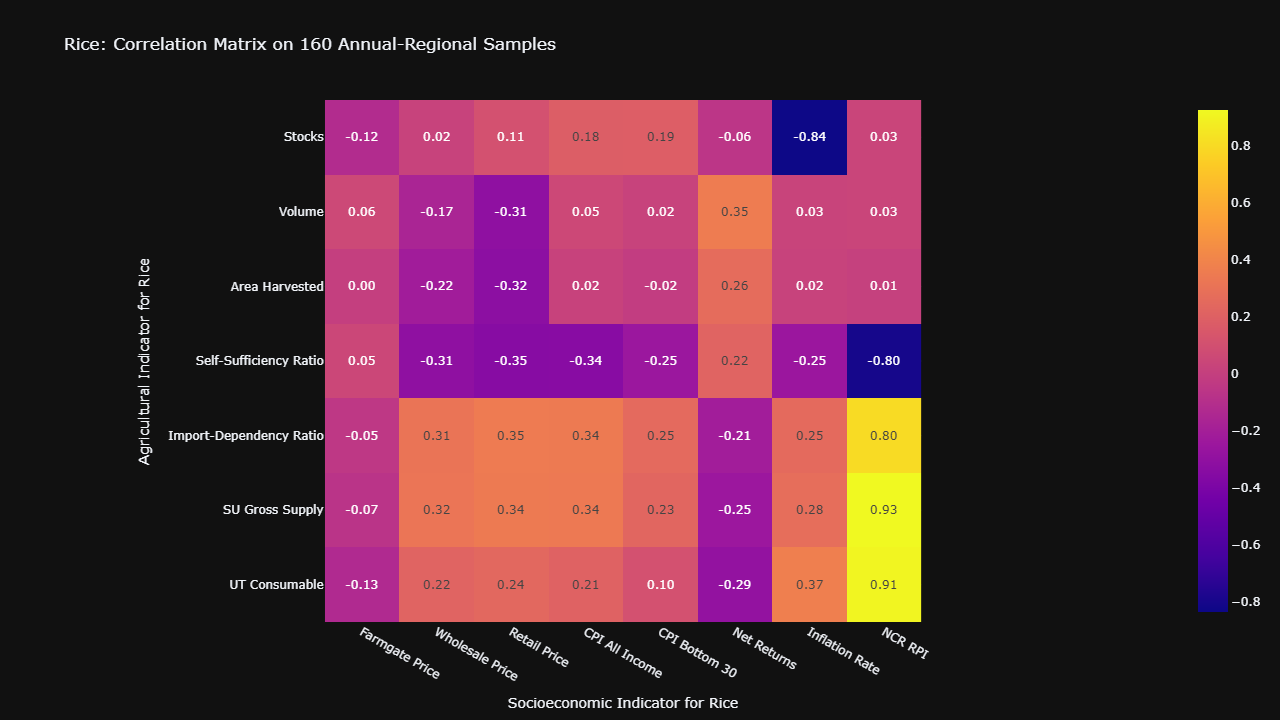

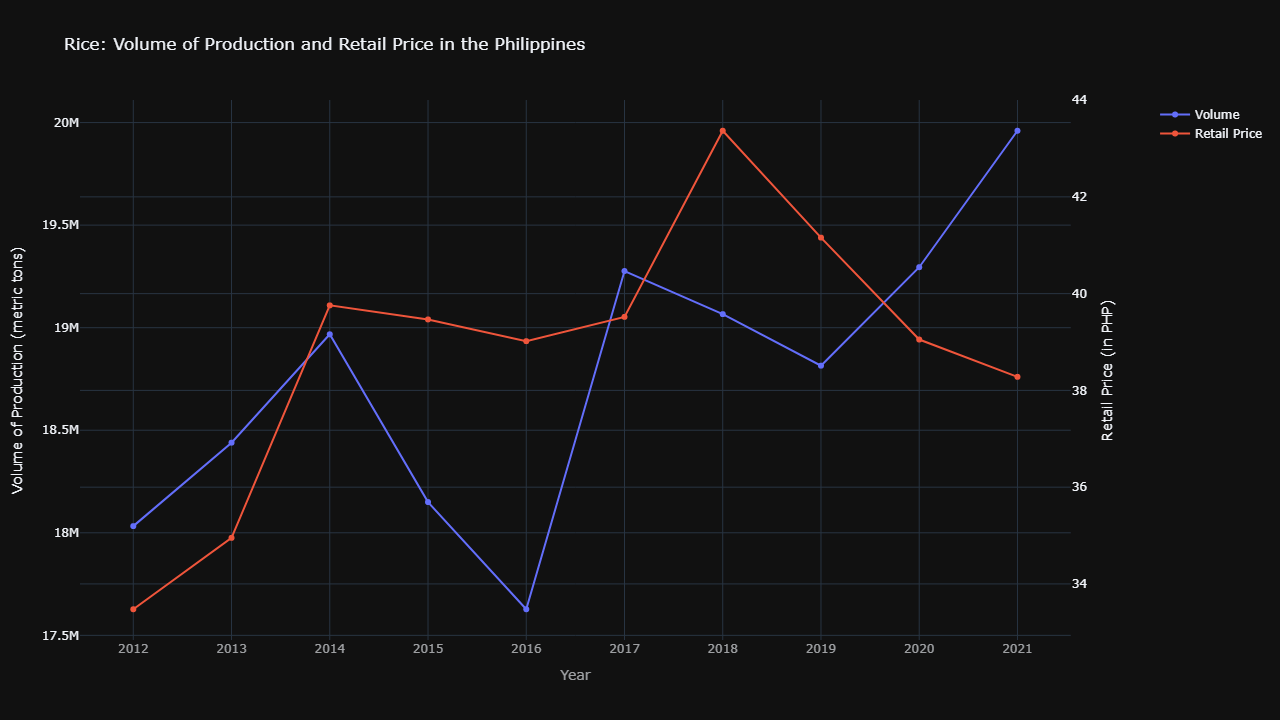

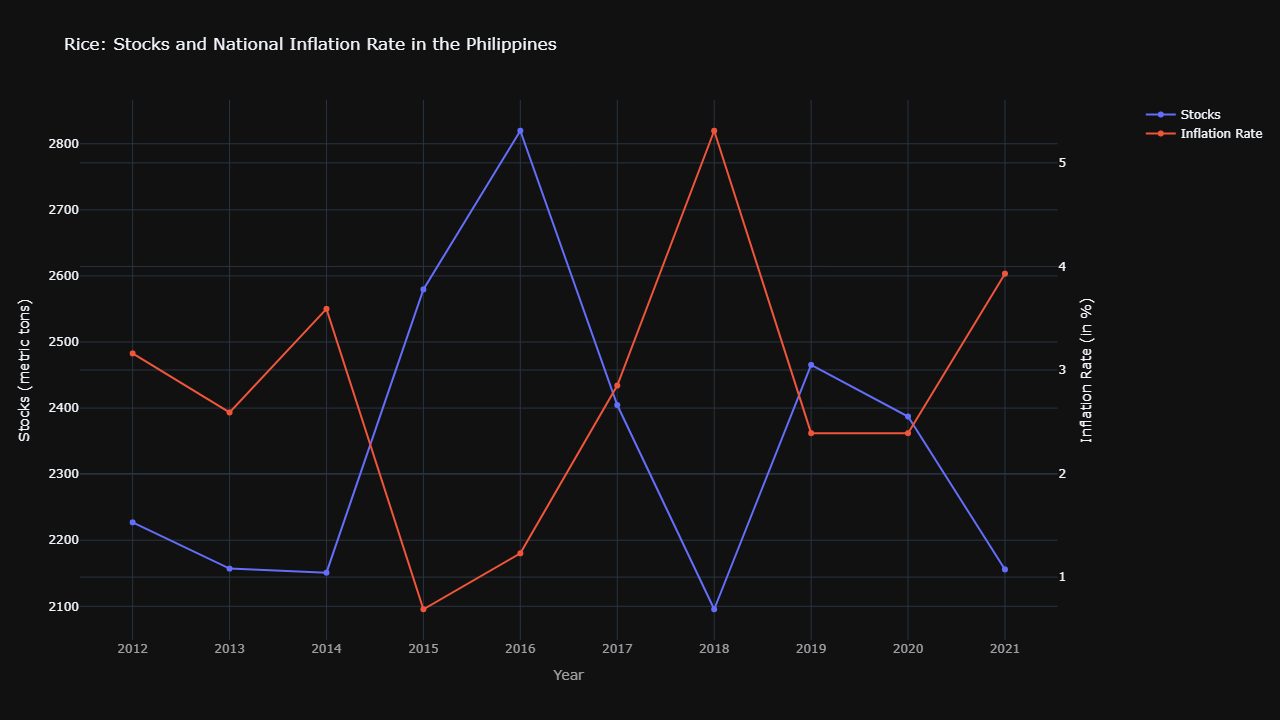

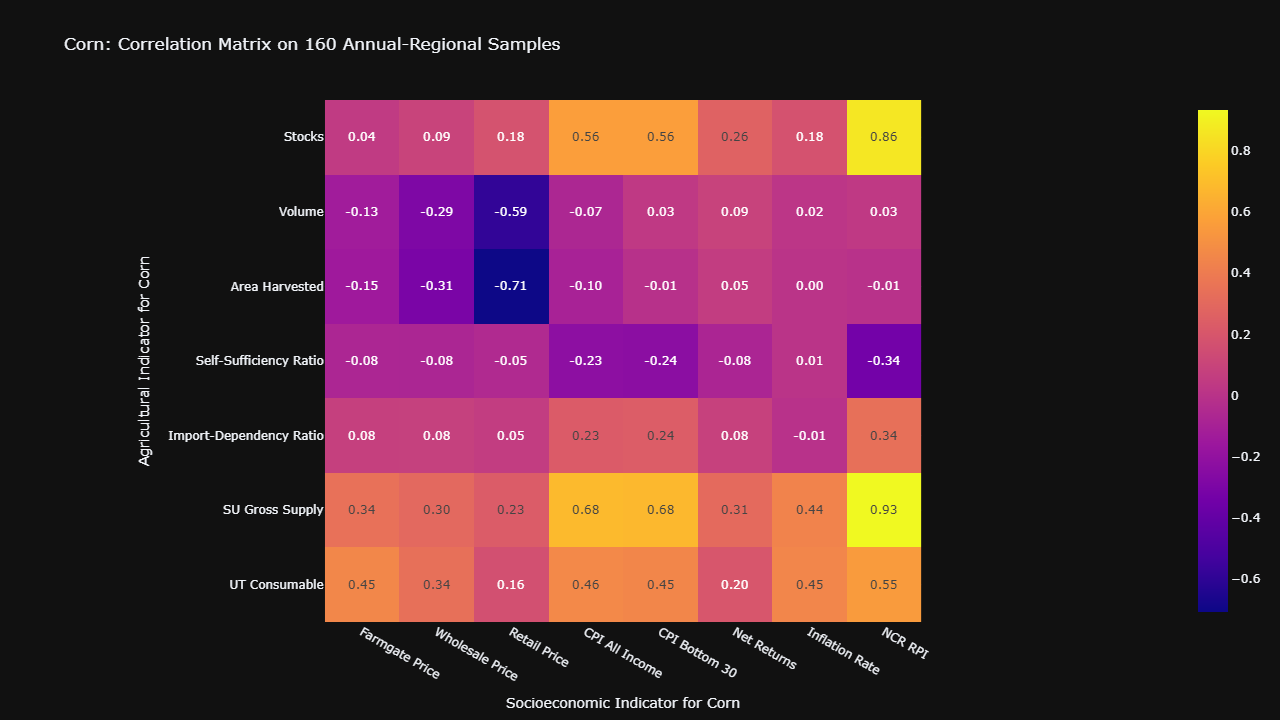

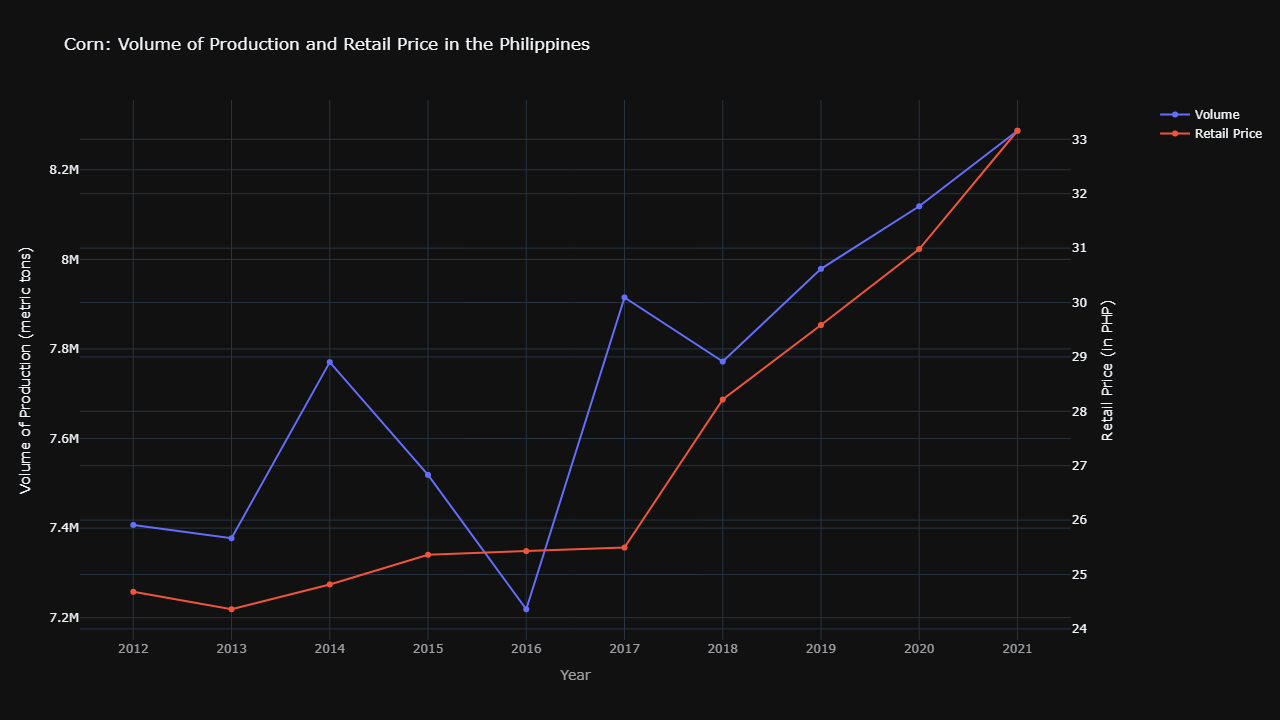

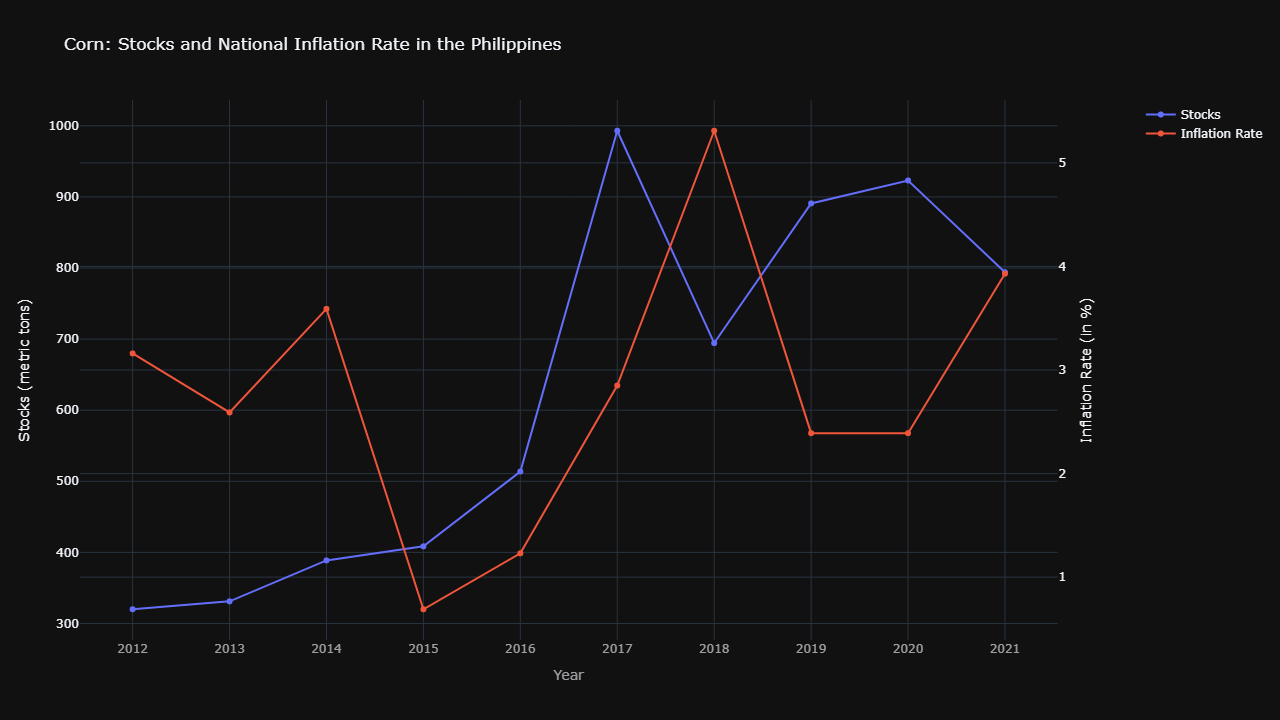

In [63]:
# @Visualizations
from termcolor import cprint

# for x in ["Volume", "Area Harvested"]:
#     for y in ["Retail Price", "Wholesale Price", "Farmgate Price", "CPI All Income", "CPI Bottom 30"]:
#         fig = px.scatter(df, x=x, y=y)
#         # render(fig)
        
# Correlation Matrix for Annual-Regions
# NOTE: Filter != or == philippines
for commodity in df["Commodity"].unique():
    tdf = df[(df["Geolocation"] != "philippines") & (df["Commodity"] == commodity)]
    samples = tdf.shape[0]
    # NOTE: pearson|kendall|spearman
    contingency = tdf.iloc[:, 3:].corr(method="pearson")
    idx = list(contingency.columns).index("Farmgate Price")
    cont_1 = contingency.iloc[:idx, idx:]
    
    # Correlation Matrix
    fig = px.imshow(cont_1, text_auto=True, title=f"{commodity}: Correlation Matrix on {samples} Annual-Regional Samples",
                    labels=dict(x=f"Socioeconomic Indicator for {commodity}", y=f"Agricultural Indicator for {commodity}"))
    fig.update_traces(
        texttemplate='%{z:.2f}',
        hovertemplate=("x: %{x}<br>y: %{y}<br><b>Correlation: %{z}</b><extra></extra>")
    )
    fig.update_layout(template="plotly_dark")
    render(fig)
    
    fig_to_div(fig, f"plots/annual-regional/{commodity}_heatmap_div.html")
    fig_to_html(fig, f"plots/annual-regional/{commodity}_heatmap.html")
    fig_to_png(fig, f"plots/annual-regional/{commodity}_heatmap.png")
    
    # Relationship of Volume and Retail Price
    mask = (df["Geolocation"] == "philippines") & (df["Commodity"] == commodity)
    fig = dual_plot(df[mask], "Period", "Volume", "Retail Price",
                    f"{commodity}: Volume of Production and Retail Price in the Philippines",
                    "Year", "Volume of Production (metric tons)", "Retail Price (in PHP)")
    fig.update_layout(template="plotly_dark", hovermode="x unified", hoverlabel=dict(bgcolor="rgba(17,17,17,0.75)"))
    fig.update_xaxes(showspikes=True, color="rgba(205,208,212,0.75)")
    render(fig)
    
    fig_to_div(fig, f"plots/annual-regional/{commodity}_dual_volume-retail_div.html")
    fig_to_html(fig, f"plots/annual-regional/{commodity}_dual_volume-retail.html")
    fig_to_png(fig, f"plots/annual-regional/{commodity}_dual_volume-retail.png")

    # Relationship of Stocks and Inflation Rate
    fig = dual_plot(df[mask], "Period", "Stocks", "Inflation Rate",
                    f"{commodity}: Stocks and National Inflation Rate in the Philippines",
                    "Year", "Stocks (metric tons)", "Inflation Rate (in %)")
    fig.update_layout(template="plotly_dark", hovermode="x unified")
    fig.update_layout(template="plotly_dark", hovermode="x unified", hoverlabel=dict(bgcolor="rgba(17,17,17,0.75)"))
    fig.update_xaxes(showspikes=True, color="rgba(205,208,212,0.75)")
    render(fig)

    fig_to_div(fig, f"plots/annual-regional/{commodity}_dual_stocks-inflation_div.html")
    fig_to_html(fig, f"plots/annual-regional/{commodity}_dual_stocks-inflation.html")
    fig_to_png(fig, f"plots/annual-regional/{commodity}_dual_stocks-inflation.png")
    
    # Hypothesis testing for commodity
    tdf = df.dropna()
    agri_cols = df.columns[3:10]
    market_cols = df.columns[10:]
    alpha = 0.05
    results = pd.DataFrame(columns=["AgriIndicator", "MarketIndicator", "r-stat", "p-value", "SigRel"])
    for x in agri_cols:
        for y in market_cols:
            agri, market = tdf[x], tdf[y]
            r_stat, p_value = stats.pearsonr(agri, market)  # Pearson's r
            if p_value < alpha:
                # cprint(f"{x} <-> {y} = {round(p_value, 3)}: Significant relationship exists.", "red")
                results.loc[len(results.index)] = [x, y, round(r_stat,3), p_report(p_value), "Exists"]
            else:
                # print(f"{x} </> {y} = {round(p_value, 3)}: No significant relationship exists.")
                results.loc[len(results.index)] = [x, y, round(r_stat,3), p_report(p_value), "Does not exist"]
    results.to_html(f"results/hypothesis2_{commodity}.html")


### Hypothesis Testing
The following hypotheses are tested at **0.05 level of signficance** (alpha=0.05):
- **H0.1:** There is no significant difference in the productivity of major food crops when grouped according to their crop type, geolocation, and/or market profile.
- **H0.2:** There is no significant relationship between market conditions and food crop production.

#### H0.1 Significant Difference Test using Two-sample t-Test

**Indicators** tested are:
- Stocks (core)
- Volume (core)
- Area Harvested (core)
- SU Gross Supply
- UT Consumable
- Farmgate Price (core)
- Wholesale Price (core)
- Retail Price (core)
- CPI All Income
- CPI Bottom 30
- Net Returns
- Inflation Rate
- NCR RPI
Tested significant difference between features of rice and corn when grouped according to geolocation.

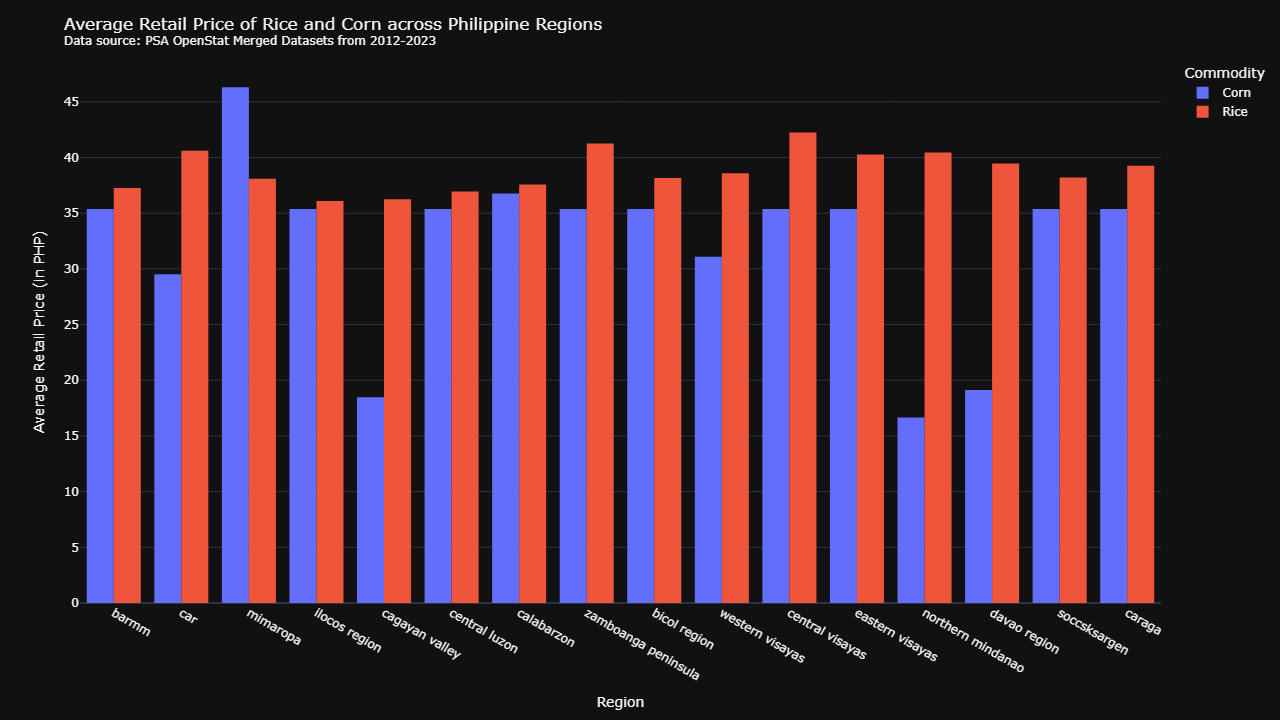

,Commodity A,Commodity B,Geolocation,Feature,t-stat,p-value,Significant Difference
0,Rice,Corn,cordillera administrative region (car),Stocks,15.489,<0.001,Exists
1,Rice,Corn,cordillera administrative region (car),Volume,15.511,<0.001,Exists
2,Rice,Corn,cordillera administrative region (car),Area Harvested,23.105,<0.001,Exists
3,Rice,Corn,cordillera administrative region (car),SU Gross Supply,17.357,<0.001,Exists
4,Rice,Corn,cordillera administrative region (car),UT Consumable,23.683,<0.001,Exists
...,...,...,...,...,...,...,...
139,Rice,Corn,bangsamoro autonomous region in muslim mindana...,UT Consumable,23.683,<0.001,Exists
140,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Farmgate Price,9.524,<0.001,Exists
141,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Wholesale Price,3.990,0.002,Exists
142,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Retail Price,NaN,NaN,Inconclusive


In [64]:
# @title Hypotheses Testing H0.1 Significant Difference Test using Two-sample t-Test
from termcolor import cprint

grouped = df[["Commodity", "Geolocation", "Retail Price"]].copy()
imputer(grouped, 2)
grouped = grouped.groupby(["Commodity", "Geolocation"])["Retail Price"].mean()
grouped = pd.DataFrame(grouped).reset_index()
grouped = grouped[grouped.Geolocation != "philippines"]
grouped["Geolocation"] = grouped["Geolocation"].replace(region_long_to_short)

fig = px.histogram(grouped, x="Geolocation", y="Retail Price",
             color='Commodity', barmode='group')
fig.update_layout(template="plotly_dark", xaxis_title="Region", yaxis_title = "Average Retail Price (in PHP)",
                  title="Average Retail Price of Rice and Corn across Philippine Regions<br><sup>Data source: PSA OpenStat Merged Datasets from 2012-2023</sup>")
fig.update_traces(hovertemplate=("Geolocation: %{x}<br><b>Avg. retail price: %{y}</b><extra></extra>"))
render(fig)

fig_to_div(fig, "plots/annual-regional/ALL_bar_retail-loc_div.html")
fig_to_html(fig, "plots/annual-regional/ALL_bar_retail-loc.html")
fig_to_png(fig, "plots/annual-regional/ALL_bar_retail-loc.png")

# Agrimarket Indicators for Annual-Regional Data
# Is there a signficant difference between the observations' <indicator> when grouped according to <category>?
# Exclude import-dependency and self-sufficiency ratios, and exlude other National Level Period (CPI, RPI, Inflation) indicators
tdf = pd.concat([df.iloc[:, 0:6], df.iloc[:, 8:13],  df.loc[:, "Net Returns"]], axis=1)
tdf = tdf[tdf.Geolocation != "philippines"]
alpha = 0.05

rice = tdf[tdf["Commodity"] == "Rice"]
corn = tdf[tdf["Commodity"] == "Corn"]
results = pd.DataFrame(columns=["Commodity A", "Commodity B", "Geolocation", "Feature",
                                "t-stat", "p-value", "Significant Difference"])
for loc in tdf["Geolocation"].unique():
    rice_loc = rice[rice["Geolocation"] == loc]
    corn_loc = corn[corn["Geolocation"] == loc]
    for var in tdf.columns[3:]:
        rice_var = rice_loc[var].dropna()
        corn_var = corn_loc[var].dropna()

        # Perform the t-test:
        t_stat, p_value = stats.ttest_ind(rice_var, corn_var)

        # Interpret the results:
        if p_value < alpha:
            results.loc[len(results.index)] = ["Rice", "Corn", loc, var, round(t_stat,3), p_report(p_value), "Exists"]
        else:
            report = "Inconclusive" if p_report(p_value) is np.nan else "Does not exist"
            results.loc[len(results.index)] = ["Rice", "Corn", loc, var, round(t_stat,3), p_report(p_value), report]
            
results.to_html("results/hypothesis1.html", index=False)
results

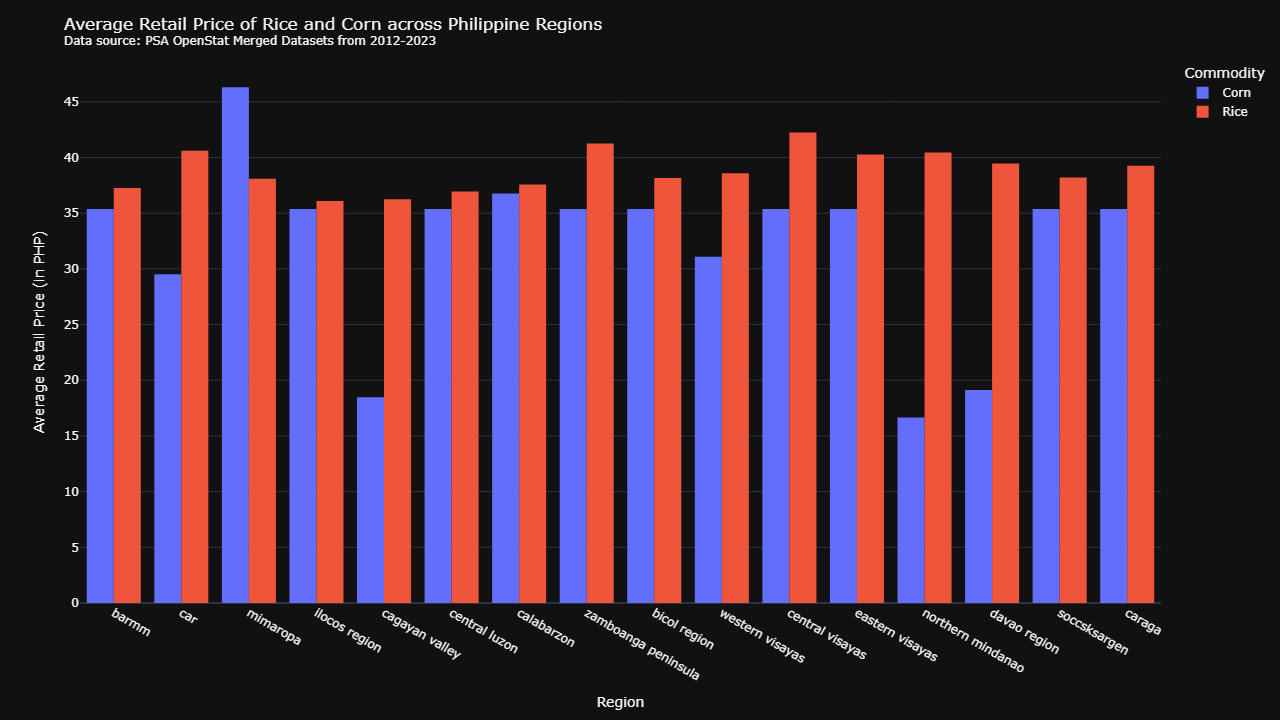

,Commodity A,Commodity B,Geolocation,Feature,t-stat,p-value,Significant Difference
0,Rice,Corn,cordillera administrative region (car),Stocks,15.489,<0.001,Exists
1,Rice,Corn,cordillera administrative region (car),Volume,15.511,<0.001,Exists
2,Rice,Corn,cordillera administrative region (car),Area Harvested,23.105,<0.001,Exists
3,Rice,Corn,cordillera administrative region (car),SU Gross Supply,17.357,<0.001,Exists
4,Rice,Corn,cordillera administrative region (car),UT Consumable,23.683,<0.001,Exists
...,...,...,...,...,...,...,...
139,Rice,Corn,bangsamoro autonomous region in muslim mindana...,UT Consumable,23.683,<0.001,Exists
140,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Farmgate Price,9.524,<0.001,Exists
141,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Wholesale Price,3.990,0.002,Exists
142,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Retail Price,NaN,NaN,Inconclusive


In [ ]:
# @title Hypotheses Testing H0.1 Significant Difference Test using Two-sample t-Test
from termcolor import cprint

grouped = df[["Commodity", "Geolocation", "Retail Price"]].copy()
imputer(grouped, 2)
grouped = grouped.groupby(["Commodity", "Geolocation"])["Retail Price"].mean()
grouped = pd.DataFrame(grouped).reset_index()
grouped = grouped[grouped.Geolocation != "philippines"]
grouped["Geolocation"] = grouped["Geolocation"].replace(region_long_to_short)

fig = px.histogram(grouped, x="Geolocation", y="Retail Price",
             color='Commodity', barmode='group')
fig.update_layout(template="plotly_dark", xaxis_title="Region", yaxis_title = "Average Retail Price (in PHP)",
                  title="Average Retail Price of Rice and Corn across Philippine Regions<br><sup>Data source: PSA OpenStat Merged Datasets from 2012-2023</sup>")
fig.update_traces(hovertemplate=("Geolocation: %{x}<br><b>Avg. retail price: %{y}</b><extra></extra>"))
render(fig)

fig_to_div(fig, "plots/annual-regional/ALL_bar_retail-loc_div.html")
fig_to_html(fig, "plots/annual-regional/ALL_bar_retail-loc.html")
fig_to_png(fig, "plots/annual-regional/ALL_bar_retail-loc.png")

# Agrimarket Indicators for Annual-Regional Data
# Is there a signficant difference between the observations' <indicator> when grouped according to <category>?
# Exclude import-dependency and self-sufficiency ratios, and exlude other National Level Period (CPI, RPI, Inflation) indicators
tdf = pd.concat([df.iloc[:, 0:6], df.iloc[:, 8:13],  df.loc[:, "Net Returns"]], axis=1)
tdf = tdf[tdf.Geolocation != "philippines"]
alpha = 0.05

rice = tdf[tdf["Commodity"] == "Rice"]
corn = tdf[tdf["Commodity"] == "Corn"]
results = pd.DataFrame(columns=["Commodity A", "Commodity B", "Geolocation", "Feature",
                                "t-stat", "p-value", "Significant Difference"])
for loc in tdf["Geolocation"].unique():
    rice_loc = rice[rice["Geolocation"] == loc]
    corn_loc = corn[corn["Geolocation"] == loc]
    for var in tdf.columns[3:]:
        rice_var = rice_loc[var].dropna()
        corn_var = corn_loc[var].dropna()

        # Perform the t-test:
        t_stat, p_value = stats.ttest_ind(rice_var, corn_var)

        # Interpret the results:
        if p_value < alpha:
            results.loc[len(results.index)] = ["Rice", "Corn", loc, var, round(t_stat,3), p_report(p_value), "Exists"]
        else:
            report = "Inconclusive" if p_report(p_value) is np.nan else "Does not exist"
            results.loc[len(results.index)] = ["Rice", "Corn", loc, var, round(t_stat,3), p_report(p_value), report]
            
results.to_html("results/hypothesis1.html", index=False)
results

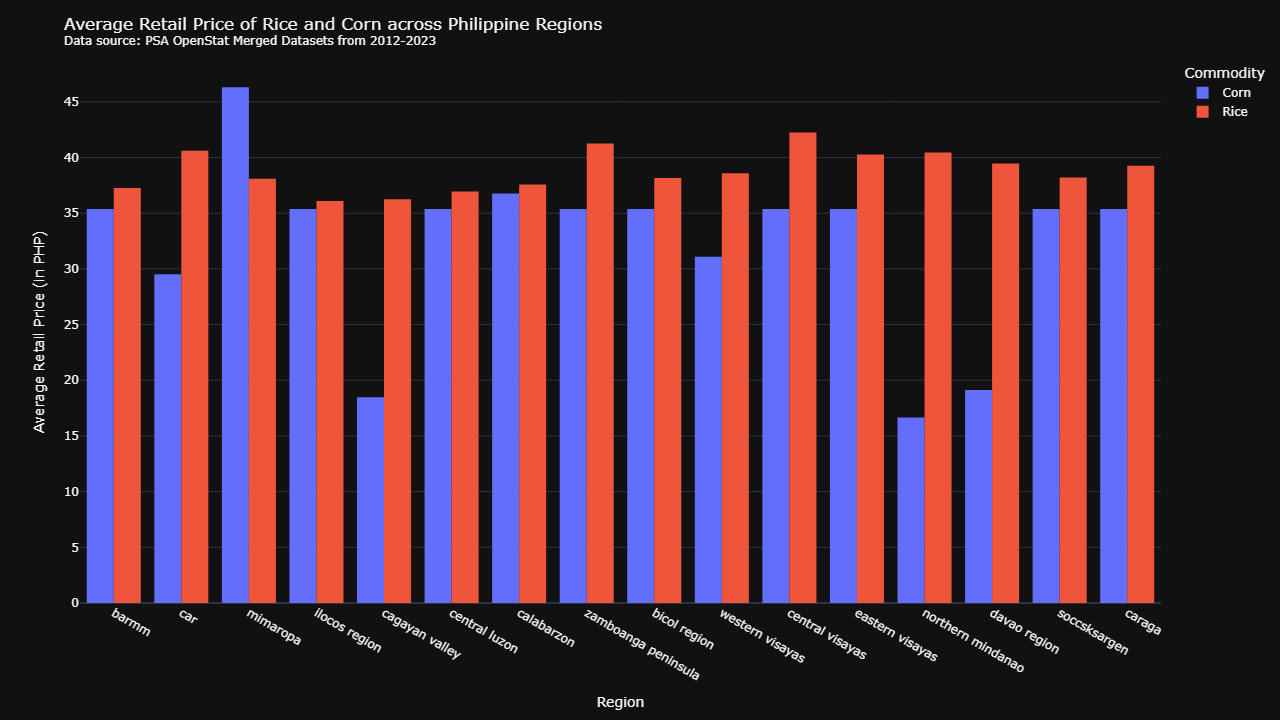

,Commodity A,Commodity B,Geolocation,Feature,t-stat,p-value,Significant Difference
0,Rice,Corn,cordillera administrative region (car),Stocks,15.489,<0.001,Exists
1,Rice,Corn,cordillera administrative region (car),Volume,15.511,<0.001,Exists
2,Rice,Corn,cordillera administrative region (car),Area Harvested,23.105,<0.001,Exists
3,Rice,Corn,cordillera administrative region (car),SU Gross Supply,17.357,<0.001,Exists
4,Rice,Corn,cordillera administrative region (car),UT Consumable,23.683,<0.001,Exists
...,...,...,...,...,...,...,...
139,Rice,Corn,bangsamoro autonomous region in muslim mindana...,UT Consumable,23.683,<0.001,Exists
140,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Farmgate Price,9.524,<0.001,Exists
141,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Wholesale Price,3.990,0.002,Exists
142,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Retail Price,NaN,NaN,Inconclusive


In [ ]:
# @title Hypotheses Testing H0.1 Significant Difference Test using Two-sample t-Test
from termcolor import cprint

grouped = df[["Commodity", "Geolocation", "Retail Price"]].copy()
imputer(grouped, 2)
grouped = grouped.groupby(["Commodity", "Geolocation"])["Retail Price"].mean()
grouped = pd.DataFrame(grouped).reset_index()
grouped = grouped[grouped.Geolocation != "philippines"]
grouped["Geolocation"] = grouped["Geolocation"].replace(region_long_to_short)

fig = px.histogram(grouped, x="Geolocation", y="Retail Price",
             color='Commodity', barmode='group')
fig.update_layout(template="plotly_dark", xaxis_title="Region", yaxis_title = "Average Retail Price (in PHP)",
                  title="Average Retail Price of Rice and Corn across Philippine Regions<br><sup>Data source: PSA OpenStat Merged Datasets from 2012-2023</sup>")
fig.update_traces(hovertemplate=("Geolocation: %{x}<br><b>Avg. retail price: %{y}</b><extra></extra>"))
render(fig)

fig_to_div(fig, "plots/annual-regional/ALL_bar_retail-loc_div.html")
fig_to_html(fig, "plots/annual-regional/ALL_bar_retail-loc.html")
fig_to_png(fig, "plots/annual-regional/ALL_bar_retail-loc.png")

# Agrimarket Indicators for Annual-Regional Data
# Is there a signficant difference between the observations' <indicator> when grouped according to <category>?
# Exclude import-dependency and self-sufficiency ratios, and exlude other National Level Period (CPI, RPI, Inflation) indicators
tdf = pd.concat([df.iloc[:, 0:6], df.iloc[:, 8:13],  df.loc[:, "Net Returns"]], axis=1)
tdf = tdf[tdf.Geolocation != "philippines"]
alpha = 0.05

rice = tdf[tdf["Commodity"] == "Rice"]
corn = tdf[tdf["Commodity"] == "Corn"]
results = pd.DataFrame(columns=["Commodity A", "Commodity B", "Geolocation", "Feature",
                                "t-stat", "p-value", "Significant Difference"])
for loc in tdf["Geolocation"].unique():
    rice_loc = rice[rice["Geolocation"] == loc]
    corn_loc = corn[corn["Geolocation"] == loc]
    for var in tdf.columns[3:]:
        rice_var = rice_loc[var].dropna()
        corn_var = corn_loc[var].dropna()

        # Perform the t-test:
        t_stat, p_value = stats.ttest_ind(rice_var, corn_var)

        # Interpret the results:
        if p_value < alpha:
            results.loc[len(results.index)] = ["Rice", "Corn", loc, var, round(t_stat,3), p_report(p_value), "Exists"]
        else:
            report = "Inconclusive" if p_report(p_value) is np.nan else "Does not exist"
            results.loc[len(results.index)] = ["Rice", "Corn", loc, var, round(t_stat,3), p_report(p_value), report]
            
results.to_html("results/hypothesis1.html", index=False)
results

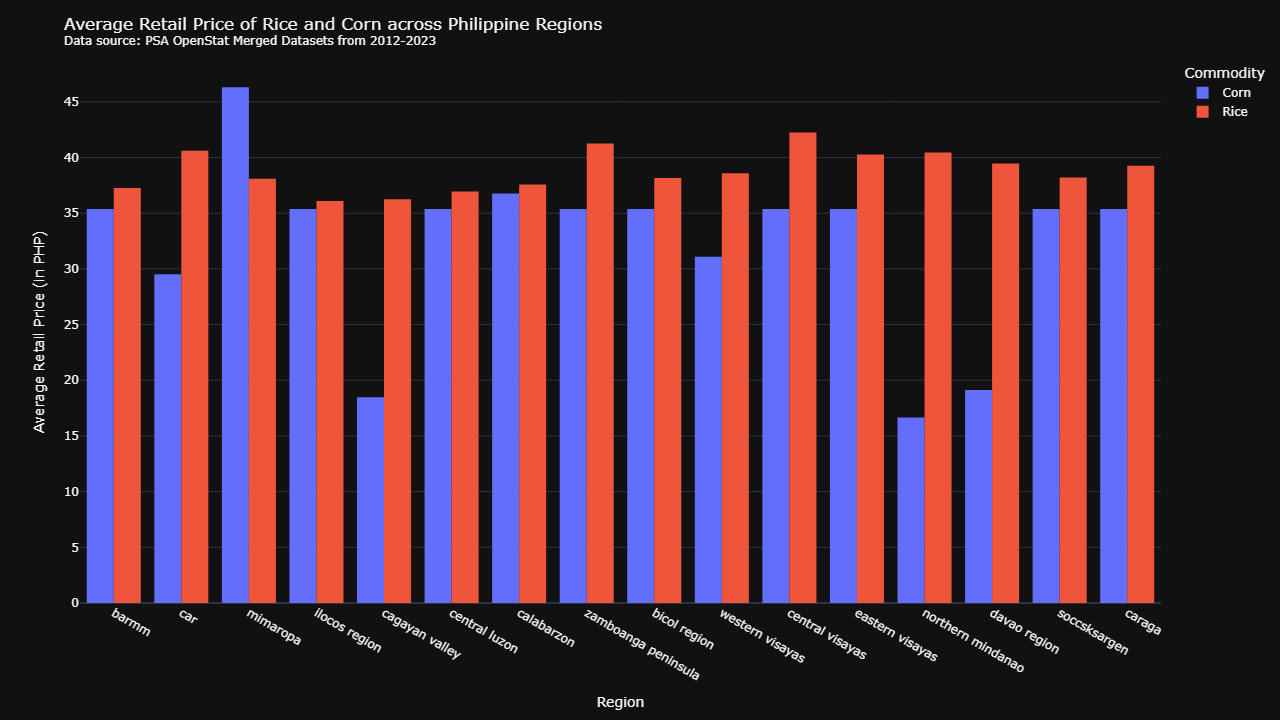

,Commodity A,Commodity B,Geolocation,Feature,t-stat,p-value,Significant Difference
0,Rice,Corn,cordillera administrative region (car),Stocks,15.489,<0.001,Exists
1,Rice,Corn,cordillera administrative region (car),Volume,15.511,<0.001,Exists
2,Rice,Corn,cordillera administrative region (car),Area Harvested,23.105,<0.001,Exists
3,Rice,Corn,cordillera administrative region (car),SU Gross Supply,17.357,<0.001,Exists
4,Rice,Corn,cordillera administrative region (car),UT Consumable,23.683,<0.001,Exists
...,...,...,...,...,...,...,...
139,Rice,Corn,bangsamoro autonomous region in muslim mindana...,UT Consumable,23.683,<0.001,Exists
140,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Farmgate Price,9.524,<0.001,Exists
141,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Wholesale Price,3.990,0.002,Exists
142,Rice,Corn,bangsamoro autonomous region in muslim mindana...,Retail Price,NaN,NaN,Inconclusive


In [ ]:
# @title Hypotheses Testing H0.1 Significant Difference Test using Two-sample t-Test
from termcolor import cprint

grouped = df[["Commodity", "Geolocation", "Retail Price"]].copy()
imputer(grouped, 2)
grouped = grouped.groupby(["Commodity", "Geolocation"])["Retail Price"].mean()
grouped = pd.DataFrame(grouped).reset_index()
grouped = grouped[grouped.Geolocation != "philippines"]
grouped["Geolocation"] = grouped["Geolocation"].replace(region_long_to_short)

fig = px.histogram(grouped, x="Geolocation", y="Retail Price",
             color='Commodity', barmode='group')
fig.update_layout(template="plotly_dark", xaxis_title="Region", yaxis_title = "Average Retail Price (in PHP)",
                  title="Average Retail Price of Rice and Corn across Philippine Regions<br><sup>Data source: PSA OpenStat Merged Datasets from 2012-2023</sup>")
fig.update_traces(hovertemplate=("Geolocation: %{x}<br><b>Avg. retail price: %{y}</b><extra></extra>"))
render(fig)

fig_to_div(fig, "plots/annual-regional/ALL_bar_retail-loc_div.html")
fig_to_html(fig, "plots/annual-regional/ALL_bar_retail-loc.html")
fig_to_png(fig, "plots/annual-regional/ALL_bar_retail-loc.png")

# Agrimarket Indicators for Annual-Regional Data
# Is there a signficant difference between the observations' <indicator> when grouped according to <category>?
# Exclude import-dependency and self-sufficiency ratios, and exlude other National Level Period (CPI, RPI, Inflation) indicators
tdf = pd.concat([df.iloc[:, 0:6], df.iloc[:, 8:13],  df.loc[:, "Net Returns"]], axis=1)
tdf = tdf[tdf.Geolocation != "philippines"]
alpha = 0.05

rice = tdf[tdf["Commodity"] == "Rice"]
corn = tdf[tdf["Commodity"] == "Corn"]
results = pd.DataFrame(columns=["Commodity A", "Commodity B", "Geolocation", "Feature",
                                "t-stat", "p-value", "Significant Difference"])
for loc in tdf["Geolocation"].unique():
    rice_loc = rice[rice["Geolocation"] == loc]
    corn_loc = corn[corn["Geolocation"] == loc]
    for var in tdf.columns[3:]:
        rice_var = rice_loc[var].dropna()
        corn_var = corn_loc[var].dropna()

        # Perform the t-test:
        t_stat, p_value = stats.ttest_ind(rice_var, corn_var)

        # Interpret the results:
        if p_value < alpha:
            results.loc[len(results.index)] = ["Rice", "Corn", loc, var, round(t_stat,3), p_report(p_value), "Exists"]
        else:
            report = "Inconclusive" if p_report(p_value) is np.nan else "Does not exist"
            results.loc[len(results.index)] = ["Rice", "Corn", loc, var, round(t_stat,3), p_report(p_value), report]
            
results.to_html("results/hypothesis1.html", index=False)
results

#### H0.2: Significant Relationship Test using Pearson's R Correlation Coefficient Test

**Agricultural Indicators** tested are:
- Stocks (core)
- Volume (core)
- Area Harvested (core)
- Self-Sufficiency Ratio
- Import-Dependency Ratio
- SU Gross Supply
- UT Consumable

**Market or Socioeconomic Indicators** tested are:
- Farmgate Price (core)
- Wholesale Price (core)
- Retail Price (core)
- CPI All Income
- CPI Bottom 30
- Net Returns
- Inflation Rate
- NCR RPI

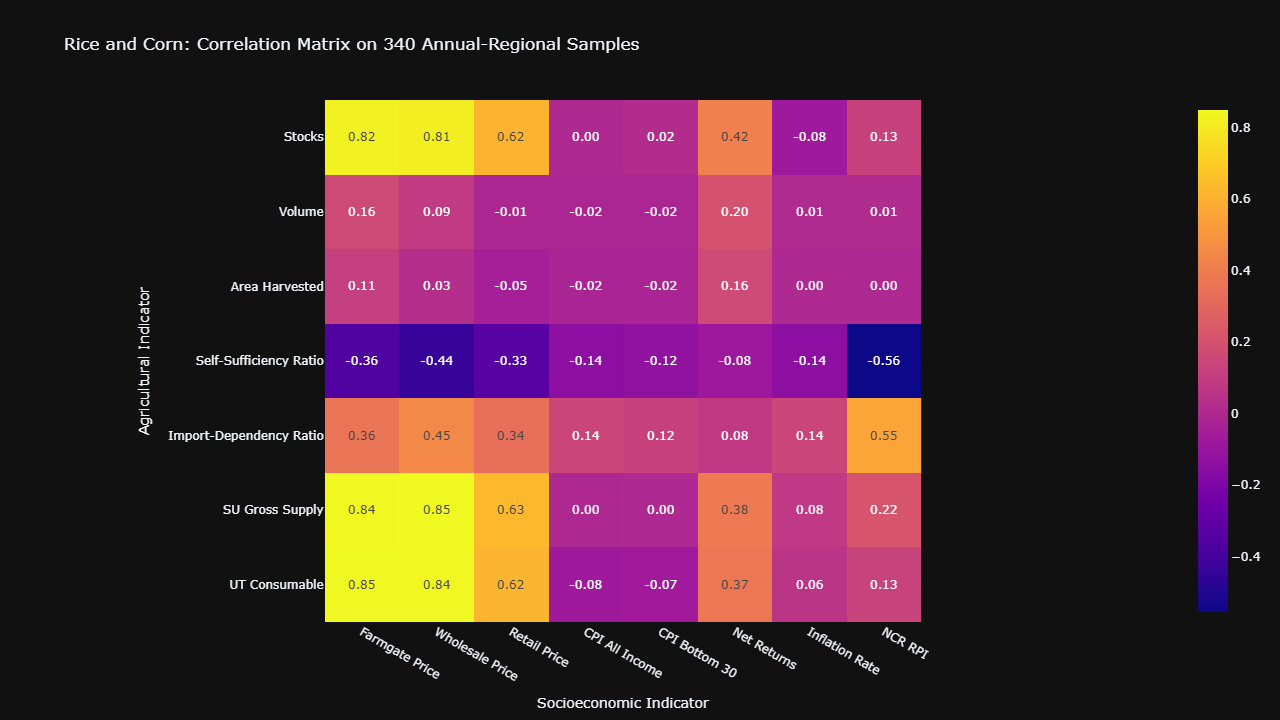

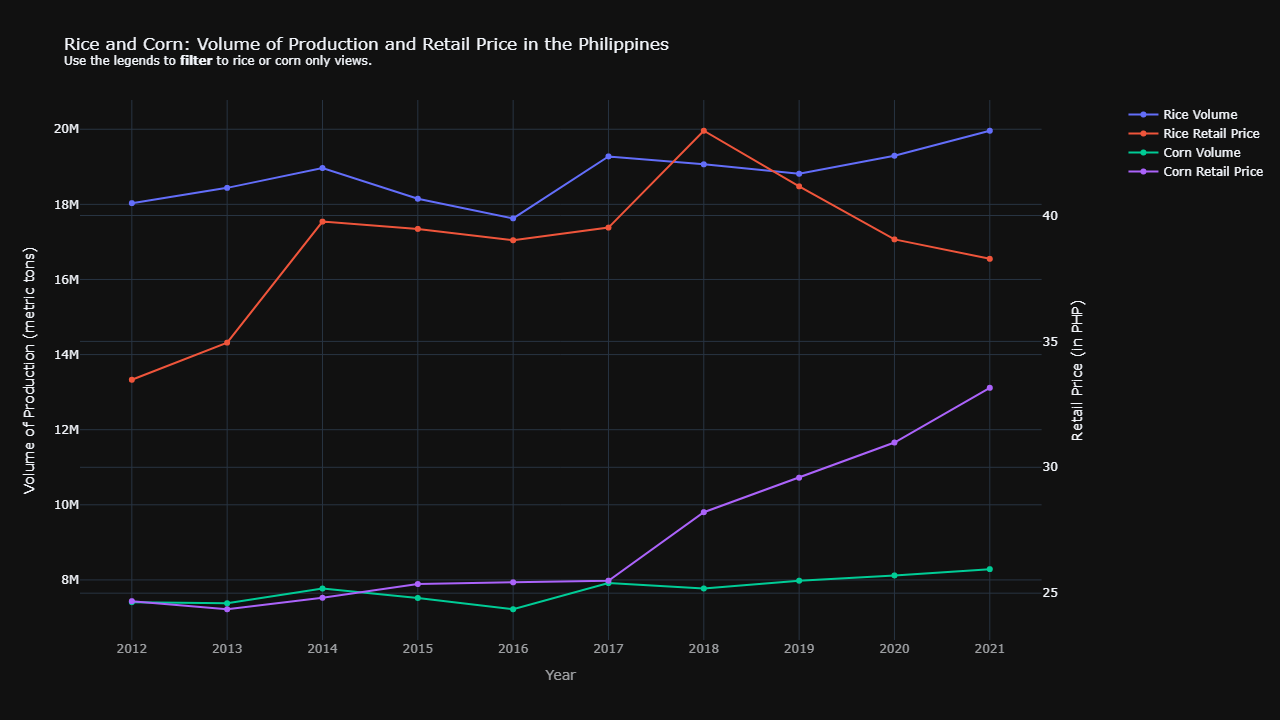

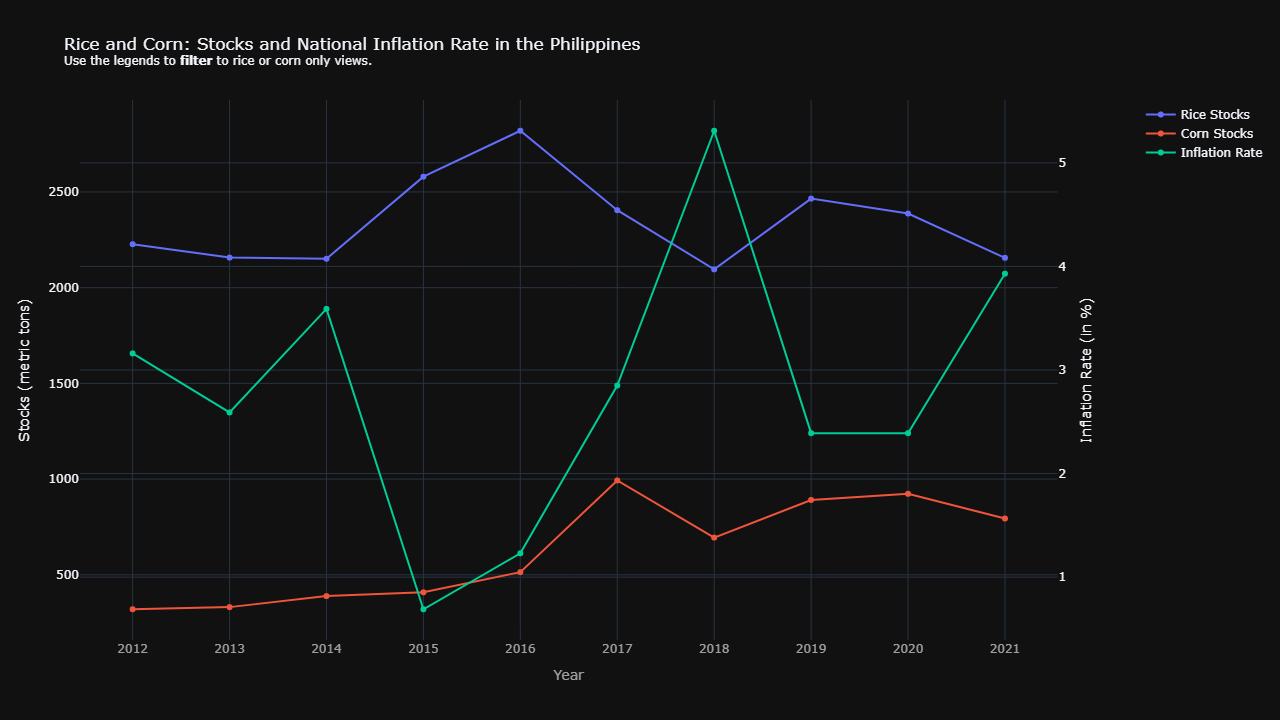

In [65]:
# @title Hypotheses Testing H0.2 Part 1: Correlation Visualization for all Commodities
# NOTE: Only Volume-RetailPrice and Stocks-InflationRate correlations have been visualized using a line plot.
#       These correspond to strong correlations you'd find at the correlation matrices (contingency).
from termcolor import cprint

# NOTE: pearson|kendall|spearman
contingency = df.iloc[:, 3:].corr(method="pearson")
idx = list(contingency.columns).index("Farmgate Price")
cont_1 = contingency.iloc[:idx, idx:]
fig = px.imshow(cont_1, text_auto=True, title=f"Rice and Corn: Correlation Matrix on {df.shape[0]} Annual-Regional Samples",
                labels=dict(x="Socioeconomic Indicator", y="Agricultural Indicator"))
fig.update_traces(
    texttemplate='%{z:.2f}',
    hovertemplate=("x: %{x}<br>y: %{y}<br><b>Correlation: %{z}</b><extra></extra>")
)
fig.update_layout(template="plotly_dark")
render(fig)

fig_to_div(fig, "plots/annual-regional/ALL_heatmap_div.html")
fig_to_html(fig, "plots/annual-regional/ALL_heatmap.html")
fig_to_png(fig, "plots/annual-regional/ALL_heatmap.png")

# QUARTET PLOT for Rice Corn Volume Retail # NOTE: Pivot tables could be used but requires more processing.
mask = (df["Geolocation"] == "philippines")    # NOTE: Philippines only for overview
tdf = df[mask][["Commodity", "Period", "Volume", "Retail Price"]].copy()
rice = tdf[tdf["Commodity"] == "Rice"].drop("Commodity", axis=1).rename(
        {"Volume": "Rice Volume", "Retail Price": "Rice Retail Price"}, axis=1)
corn = tdf[tdf["Commodity"] == "Corn"].drop("Commodity", axis=1).rename(
        {"Volume": "Corn Volume", "Retail Price": "Corn Retail Price"}, axis=1)
tdf = pd.merge(rice, corn, on=["Period"])

fig = quartet_plot(tdf, "Period", "Rice Volume", "Rice Retail Price", "Corn Volume", "Corn Retail Price",
                "Rice and Corn: Volume of Production and Retail Price in the Philippines<br><sup>Use the legends to <b>filter</b> to rice or corn only views.</sup>",
                "Year", "Volume of Production (metric tons)", "Retail Price (in PHP)")
fig.update_layout(template="plotly_dark", hovermode="x unified", hoverlabel=dict(bgcolor="rgba(17,17,17,0.75)"))
fig.update_xaxes(showspikes=True, color="rgba(205,208,212,0.75)")
render(fig)

fig_to_div(fig, "plots/annual-regional/ALL_vol-retail_div.html")
fig_to_html(fig, "plots/annual-regional/ALL_vol-retail.html")
fig_to_png(fig, "plots/annual-regional/ALL_vol-retail.png")

# TRIPLET PLOT for Rice Corn Stocks Inflation
mask = (df["Geolocation"] == "philippines")    # NOTE: Philippines only for overview
tdf = df[mask][["Commodity", "Period", "Stocks", "Inflation Rate"]].copy()
rice = tdf[tdf["Commodity"] == "Rice"].drop("Commodity", axis=1).rename(
        {"Stocks": "Rice Stocks"}, axis=1)
corn = tdf[tdf["Commodity"] == "Corn"].drop("Commodity", axis=1).rename(
        {"Stocks": "Corn Stocks"}, axis=1)
tdf = pd.merge(rice, corn, on=["Period", "Inflation Rate"])

fig = triplet_plot(tdf, "Period", "Rice Stocks", "Corn Stocks", "Inflation Rate",
                "Rice and Corn: Stocks and National Inflation Rate in the Philippines<br><sup>Use the legends to <b>filter</b> to rice or corn only views.</sup>",
                "Year", "Stocks (metric tons)", "Inflation Rate (in %)")
fig.update_layout(template="plotly_dark", hovermode="x unified", hoverlabel=dict(bgcolor="rgba(17,17,17,0.75)"))
fig.update_xaxes(showspikes=True, color="rgba(205,208,212,0.75)")
render(fig)

fig_to_div(fig, "plots/annual-regional/ALL_stocks-inflation_div.html")
fig_to_html(fig, "plots/annual-regional/ALL_stocks-inflation.html")
fig_to_png(fig, "plots/annual-regional/ALL_stocks-inflation.png")

In [66]:
# Hypothesis Testing H0.2 Part 2: Significant Relationship Test using Pearson's r
# NOTE: Agri and Market Indicators for Annual-Regional Data
tdf = df.dropna()
agri_cols = df.columns[3:10]
market_cols = df.columns[10:]
alpha = 0.05
results = pd.DataFrame(columns=["AgriIndicator", "MarketIndicator", "r-stat", "p-value", "SigRel"])
for x in agri_cols:
    for y in market_cols:
        agri, market = tdf[x], tdf[y]
        r_stat, p_value = stats.pearsonr(agri, market)  # Pearson's r
        if p_value < alpha:
            results.loc[len(results.index)] = [x, y, round(r_stat,3), p_report(p_value), "Exists"]
        else:
            results.loc[len(results.index)] = [x, y, round(r_stat,3), p_report(p_value), "Does not exist"]
results.to_html("results/hypothesis2.html", index=False)
results

,AgriIndicator,MarketIndicator,r-stat,p-value,SigRel
0,Stocks,Farmgate Price,0.686,<0.001,Exists
1,Stocks,Wholesale Price,0.780,<0.001,Exists
2,Stocks,Retail Price,0.829,<0.001,Exists
3,Stocks,CPI All Income,0.061,0.405,Does not exist
4,Stocks,CPI Bottom 30,0.203,0.005,Exists
5,Stocks,Net Returns,0.182,0.012,Exists
6,Stocks,Inflation Rate,-0.208,0.004,Exists
7,Stocks,NCR RPI,0.108,0.14,Does not exist
8,Volume,Farmgate Price,-0.062,0.401,Does not exist
9,Volume,Wholesale Price,-0.082,0.262,Does not exist


### Additional Exploration

In [67]:
# NOTE: Choropleth Maps
from urllib.request import urlopen
import json
url = "https://raw.githubusercontent.com/faeldon/philippines-json-maps/master/2023/geojson/country/lowres/country.0.001.json"
with urlopen(url) as response:
    counties = json.load(response)

# fips_mapping = {}
# for i in range(len(counties["features"])):
#     fips_mapping.update({counties["features"][i]["properties"]['adm1_en'].lower(): counties["features"][i]["id"]})
# fips_mapping["mimaropa region (mimaropa)"] = 1700000000
# fips_mapping
for i in range(len(counties["features"])):
    counties["features"][i]["properties"]['adm1_en'] = counties["features"][i]["properties"]['adm1_en'].lower()

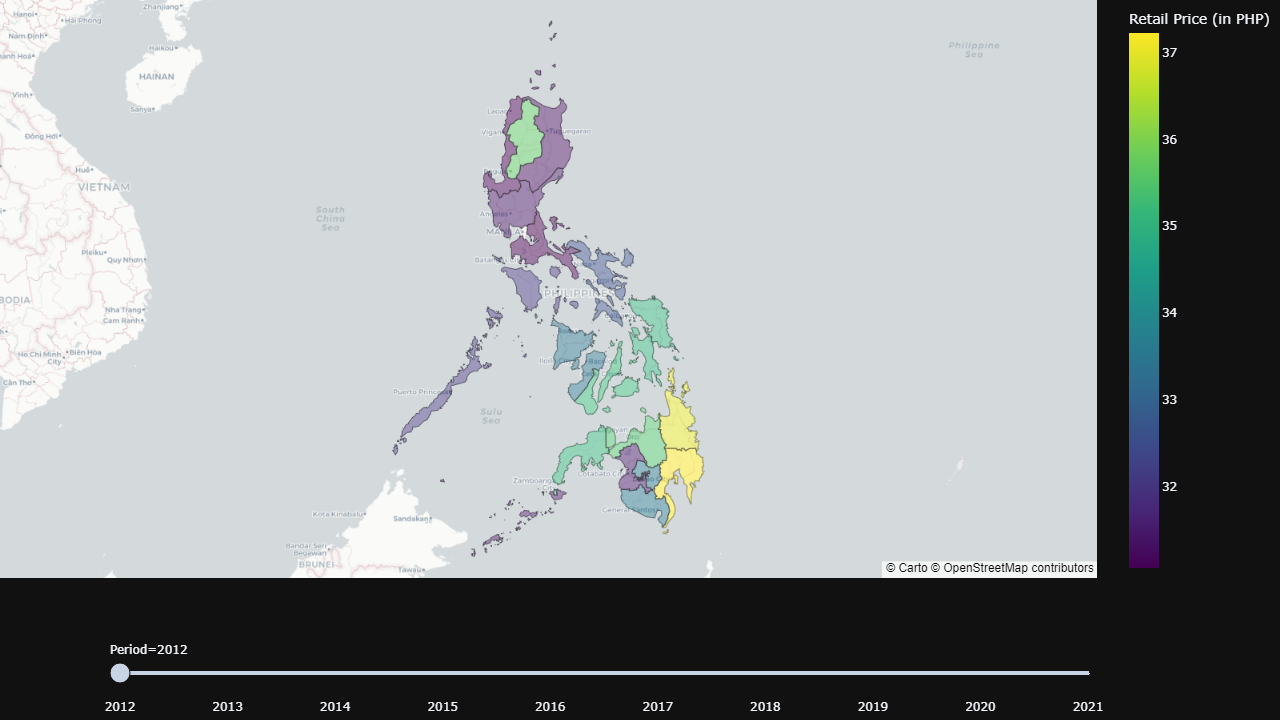

In [68]:
tdf = df.copy()
# tdf["FIPS"] = tdf["Geolocation"].replace(fips_mapping)
mask = (tdf["Geolocation"] != "philippines") & (tdf["Commodity"] == "Rice")
tdf["Geolocation"] = tdf["Geolocation"].apply(lambda x: "mimaropa region" if x == "mimaropa region (mimaropa)" else x)
tdf = tdf[mask]

# long: 12.8797° N, lat: 121.7740° E

var = "Retail Price"
fig = px.choropleth_mapbox(tdf, geojson=counties, locations='Geolocation', color=var,
                           featureidkey = "properties.adm1_en",
                           mapbox_style="carto-positron",
                           color_continuous_scale="viridis",
                           zoom=4.5, center = {"lat": 12.8700, "lon": 121.7740},
                           opacity=0.5,
                           labels={f'{var}':f'{var} (in PHP)'},
                           hover_data=["Geolocation", "Retail Price"],
                           animation_frame="Period",
                           animation_group="Geolocation"
                          )
fig.update_layout(
        autosize=False,
        hoverlabel=dict(bgcolor="rgba(17,17,17,0.75)"),
        margin = dict(
                l=0,
                r=0,
                b=0,
                t=0,
                pad=4,
                autoexpand=True),
        width=640,
        height=640,
        template="plotly_dark"
    )
fig["layout"].pop("updatemenus") # optional, drop animation buttons
render(fig)

del fig


In [ ]:
# agri_inds = ["Stocks", "Volume", "Area Harvested", "Self-Sufficiency Ratio", "SU Gross Supply", "UT Consumable"]
# market_inds = ["Retail Price", "Wholesale Price", "Farmgate Price", "CPI All Income", "CPI Bottom 30", "Net Returns", "Inflation Rate", "NCR RPI"]
# specs = [[{"l": 1, "r": 1, "b":1, "t": 1} for i in range(len(agri_inds))] for j in range(len(market_inds))]
# fig1 = make_subplots(rows=len(market_inds), cols=len(agri_inds),
#                      x_title="Socioeconomic Indicators", y_title="Agricultural Indicators",
#                      row_titles=market_inds, column_titles=agri_inds)
# fig2 = make_subplots(rows=len(market_inds), cols=len(agri_inds),
#                      row_heights=[50 for i in range(len(market_inds))],
#                      column_widths=[100 for i in range(len(agri_inds))])
# rice = df[df.Commodity == "Rice"]
# corn = df[df.Commodity == "Corn"]
# for i, x in enumerate(market_inds):
#     for j, y in enumerate(agri_inds):
#         fig1.add_trace(go.Scatter(x=rice[x], y=rice[y], mode='markers'), row=i+1, col=j+1)
#         fig2.add_trace(go.Scatter(x=corn[x], y=corn[y], mode='markers'), row=i+1, col=j+1)
# render(fig1)
# render(fig2)

# imputer(df, 10)
# df.isnull().sum()